# Analysis of the Clearer Thinking: Value of Time Calculator data

[Clearer Thinking](https://www.clearerthinking.org/) is a website with research-based interactive tools and tests that help users understand themselves more deeply, form new positive habits, and make better decisions.

One of the tools on the website is the [Value of Time Calculator](https://programs.clearerthinking.org/what_is_your_time_really_worth_to_you.html), a test that helps respondents reflect on and discover how much monetary value they assign to their free time. 

Since the publishing of the tool, hundreds of thousands of people used the test. The analysis in this notebook is based on a slice of the full data set including 13958 usages of the program.

The goal of th enotebook is to explore the dataset numerically and visually, find out if there are any interesting trends or correlations.

## Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

In [2]:
tv = pd.read_excel('clearerthinking.xlsx', encoding='ascii')

In [3]:
tv.head()

,Run,Program Version,Time Started (UTC),Time Finished (UTC),Minutes Spent,Position,Points,weeklywage,wageorsalary,transferquestion,...,"Do you have one job, or do you work several jobs? (umadzt9)","At your 2nd job, how many hours do you work *per week* in total, on weeks when you are not on vacation? (tqli88s)","Do you know roughly how much your 2nd job pays you *on an hourly basis*, including benefits? (00)",What is your current *annual after-tax salary*? (tlotksk),"Are you paid an hourly wage by your job, or do you draw an annual salary? (-xk33y2j)","Are you paid an hourly wage by your 1st job, or do you draw an annual salary? (-xk33y2j)","What's the minimum *hourly* wage you would be willing to accept for this job, under the conditions described above? (00)",Do you enjoy your current work? (00),What is your current *after-tax annual* salary? (00),What's the total value of any dental insurance you receive every year at this job? (00)
0,1038685,2,NaT,NaT,NaN,vlph7u0,0,760.961538,0,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1038869,5,NaT,NaT,6.87,1nbnhh3,0,0.000000,0,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1038883,5,NaT,NaT,NaN,ddn4yjl,0,951.826923,2,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1038885,5,NaT,NaT,NaN,vlph7u0,0,3115.384615,0,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1038892,5,NaT,NaT,NaN,vlph7u0,0,2490.384615,2,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
tv_num = tv.select_dtypes(include=['float64', 'int64'])
print(tv_num.shape)
tv_num.columns

(13958, 180)


Index(['Run', 'Program Version', 'Minutes Spent', 'Points', 'weeklywage',
       'wageorsalary', 'transfer', 'totalweeks', 'totalhoursyearly',
       'totalannualwage',
       ...
       'Do you have one job, or do you work several jobs? (umadzt9)',
       'At your 2nd job, how many hours do you work *per week* in total, on weeks when you are not on vacation? (tqli88s)',
       'Do you know roughly how much your 2nd job pays you *on an hourly basis*, including benefits? (00)',
       'What is your current *annual after-tax salary*? (tlotksk)',
       'Are you paid an hourly wage by your job, or do you draw an annual salary? (-xk33y2j)',
       'Are you paid an hourly wage by your 1st job, or do you draw an annual salary? (-xk33y2j)',
       'What's the minimum *hourly* wage you would be willing to accept for this job, under the conditions described above? (00)',
       'Do you enjoy your current work? (00)',
       'What is your current *after-tax annual* salary? (00)',
       'What's 

### Explanation of variables:

There are 423 columns in the original dataset. Most of them are not useful, or have been used as intermediary steps to find other values.

Based on notes from Spencer Greenberg and the source code of the Value Of time Test we've identified columns/variables that could be helpful for our later analysis:

* `hoursweekly` = totalhoursyearly / 52
* `weeklywage` = totalannualwage / 52
* `currentwage` = totalannualwage / totalhoursyearly
* `onejobhoursweekly` answer to: At your {`jobsText`}, how many hours do you work *per week* in total, on weeks when you are not on vacation?
* `paidweeks` = How many weeks do you work every year at this job?
* `jobask` = How many jobs the person has if more than 1.
* `jobnumber` = number of jobs the person has
* `enjoy` = answer to = Do you enjoy your current work? (yes, no, somewhat)
* `employment` = is the person emplyed (1), or not (0)
* `Z`= hoursweekly * currentwage
* `symbol` = currency symbol (`choseOtherCurrency` =1, if currency 'Other' was chosen
* `jobtotal` = ?
* `wageorsalary` = Are you paid an hourly wage by your {jobsText}, or do you draw an annual salary? (wage =1, salary=2)
* `E` = final value of time per h. (calculated using formulas from line 599)

**Value *hourminimum* comes from the hourminimum question:**
Suppose that your current main job disappears, but you immediately come across an opportunity to take a very similar job at which you'd do work that you like about as much as your current work, and at which you'd work about the same number of hours per week. Also suppose that you feel confident in your ability to find another stable job even if you pass up this opportunity.
* `hourminimum` =  Answer to: What's the minimum *hourly, after-tax wage* you would be willing to accept for this job, under the conditions described above?

**Value *A* comes from the parttime question:**
Say someone offers you a part-time job that you only do for *one hour per week*, on top of your current work. Suppose that this part-time job involves neutral work that you neither like nor dislike, and ("it doesn't conflict with your main job in any way — their schedules don't overlap and your employers at your main job don't mind if you take on outside work" or "your current schedule in any way"). You're also not going to really learn anything new by doing this work.
`parttime` = answer to How much money *per hour, after tax,* would someone have to offer you to take this job?
`A` = parttime
    
**Value *B* comes from the chores question:**
Say you have a neutral (i.e. neither pleasant nor unpleasant) 4-hour personal task to take care of this weekend. You also have the opportunity to pay for the use of a machine which would allow you to complete the task in just *2 minutes, instead of 4 hours.*
* `chore` = answer to What's the maximum amount of money you'd be willing to pay to use this machine? 
* `B` = chore /4 (value per hour of skipping chores)


**Value *C* comes from the gift certificate question:**
Say you come across an opportunity to get a {symbol}100 gift certificate to a store that you shop at very regularly, but the promotion requires you to wait in line at the store to receive your certificate. Suppose that you have some form of minimal entertainment with you, so the time you spend waiting will be neither especially pleasant nor especially unpleasant.
* `certif` = How long *in minutes* would you be willing to wait for it?
* `C` = 100 / (certif/60)


**Value *D* comes from the transfer question:**

Say you're offered a transfer within your company. If you take the transfer, your new position would involve doing work that you enjoy about as much as your current work, but that would require you to work 10% more hours per week than your current job does. On the bright side, if you take this transfer, you also get a raise, and you won't have to move from your current home.

* `transfer` =  answer to: What's the minimum *total* amount of money this new position would have to pay you *per week, after tax,* in order for you to take it?
* `D` = (transfer - (hoursweekly * currentwage)) / (hoursweekly * 0.1)
    - enjoy = "Somewhat"
        * D = (transfer - (hoursweekly * currentwage)) / (hoursweekly * 0.1)
    -  enjoy = "No"
        * D = ((transfer - (hoursweekly * currentwage)) / (hoursweekly * 0.1)) / 1.037

Only people with employment=1 and one job got  `transferquestion`

Others get:

Imagine that you're in a city you haven't visited before. You've got plans on the other side of town, but they're way too far away for you to walk there. In this particular city, you have 2 options: you can take the local train, which is cheap, or you can take the express train, which is more expensive but which will *save you a full hour of travel time.* (Suppose your plans aren't time-sensitive, and that you don't have anything fun to do on the train — you'll just be waiting in your seat throughout the ride, and there isn't really anything to see outside the window.)
* train = `D`

Based on this selection we can create a base table.

In [5]:
base_tv = tv[['employment', 'wageorsalary','symbol','choseOtherCurrency','currentwage','A','B','C','E',
    'hoursweekly','Z','enjoy','transfer', 'D', 
    'hourminimum','jobnumber','weeklywage','jobask',
    'totalweeks','totalhoursyearly','totalannualwage','transferquestion',
    'jobtotal']]
base_tv.head()

,employment,wageorsalary,symbol,choseOtherCurrency,currentwage,A,B,C,E,hoursweekly,...,D,hourminimum,jobnumber,weeklywage,jobask,totalweeks,totalhoursyearly,totalannualwage,transferquestion,jobtotal
0,1,0,$,0,20.086294,20.0,12.5,2.000000e+02,20.000000,37.884615,...,20.000000,25.0,2.0,760.961538,2,0,1970.0,39570.0,no,0
1,0,0,$,0,0.000000,30.0,58524558.5,1.850656e-10,47.500000,0.000000,...,65.000000,0.0,0.0,0.000000,0,0,0.0,0.0,no,0
2,1,2,$,0,21.151709,30.0,12.5,5.000000e+01,31.463675,45.000000,...,32.927350,22.0,1.0,951.826923,1,0,2340.0,49495.0,yes,0
3,1,0,$,0,75.000000,100.0,25.0,1.200000e+03,120.370370,41.538462,...,140.740741,60.0,1.0,3115.384615,1,0,2160.0,162000.0,yes,0
4,1,2,$,0,49.807692,49.0,12.5,5.000000e+01,49.500000,50.000000,...,101.923077,49.0,1.0,2490.384615,1,0,2600.0,129500.0,yes,0


In [6]:
base_tv.shape

(13958, 23)

In [7]:
# create a list of columsn where d type is object
objs = []
for n in range(0,len(base_tv.dtypes)):
    i = base_tv.dtypes.index[n]
    if base_tv.dtypes[n] == 'O':
        objs.append(i)

In [8]:
# remove obj clumns temporarily to be able to filter by numerical values
base_tv_noobj = base_tv.drop(columns=objs)

#check for values lower than 0
base_tv_noobj[base_tv_noobj<0].notna().sum()

employment              0
wageorsalary            0
choseOtherCurrency      0
currentwage             2
A                       0
B                       0
C                       0
E                       0
hoursweekly             0
Z                       2
transfer                0
D                     218
hourminimum             0
jobnumber               0
weeklywage              2
jobask                  0
totalweeks              0
totalhoursyearly        0
totalannualwage         2
jobtotal                0
dtype: int64

There are two rows wher the current wage and total annual wage are entered as negative. We can investigate these. Perhaps these are people who don't earn, but are paying off a debt? (Rare but possible.)

In [9]:
base_tv_noobj[base_tv_noobj['currentwage']<0]

,employment,wageorsalary,choseOtherCurrency,currentwage,A,B,C,E,hoursweekly,Z,transfer,D,hourminimum,jobnumber,weeklywage,jobask,totalweeks,totalhoursyearly,totalannualwage,jobtotal
1613,1,2,0,-4.327619,30.0,20.0,50.0,25.0,50.480769,-218.461538,0.0,10.0,35.0,2.0,-218.461538,2,0,2625.0,-11360.0,0
3096,1,0,0,-933.840757,20.0,10.0,50.0,15.0,31.519231,-29433.942308,0.0,10.0,15.0,5.0,-29433.942308,5,0,1639.0,-1530565.0,0


The two values have employment= 1 and negative earnings. We can assume these were mistakenly put values/values added as a joke and remove them, as they might skew later results.

In [10]:
#remove negative values
base_tv = base_tv[base_tv.currentwage >= 0.0]

In [11]:
base_tv.shape

(13913, 23)

More than 2 values were removed (45), looks like there were more than two negative values in this column.

There are also 218 records in the dataframe where the answer to question D has a negative value. But, looking at the formula that generates the answer this is a plausible result.

## Currencies & missing values

There are several currencies in the dataset, respondents give values with their currency in mind. The distribution of values entered each currency can differ, which is something to bear in mind for later analysis.

Performing later calculations, or filling in missing values (if necessary) would be best done based on currency groupings.

In [12]:
# check if any participant used other curency than the main ones
base_tv['choseOtherCurrency'].value_counts()

0    13913
Name: choseOtherCurrency, dtype: int64

There are no other currencies than dollars, rupees, pounds, rubles, euros, shekels, or pesos in the data frame.

In [13]:
base_tv['symbol'].value_counts(dropna=False)

$      10581
‚Ç¨     1894
¬£      1018
‚Ç™      225
INR      166
RUB       29
Name: symbol, dtype: int64

Thre are two unknown symbols here ‚Ç¨ and ‚Ç™. Given the choices given in the answer to the currency question one has to be euros and the other shekels. Given the worldwide usage of these, I'm assuming ‚Ç¨ is euros and ‚Ç™ is shekels.

In [14]:
# replace values with ISO 4217 currency codes
base_tv['symbol'] = base_tv['symbol'].replace('‚Ç™', 'NIS').replace("¬£", "GBP").replace("‚Ç¨", "EUR")

In [15]:
#dropping nans if there are any in that column
base_tv['symbol'].dropna(inplace=True)

In [16]:
# group the dataframe by symbol
currency_grouped = base_tv.groupby(by='symbol')

In [17]:
#check means in column E per currency
currency_grouped_means = currency_grouped.mean()
currency_grouped_means['E'].apply(lambda x: '%.1f' % x)

symbol
$      1181921331316187629690177482364825212726422367...
EUR                                                 43.2
GBP          49115913556483304672369347560493564297216.0
INR                                              15961.6
NIS                                                220.5
RUB                                       215517244141.1
Name: E, dtype: object

Very high means for $ and GBP suggest the presence of outliers. 
**Decision**: We'll have to remove them from each currency group.

In [18]:
# check for nans
base_tv.isna().sum()

employment              0
wageorsalary            0
symbol                  0
choseOtherCurrency      0
currentwage             0
A                       2
B                       2
C                     113
E                       6
hoursweekly             0
Z                       0
enjoy                   0
transfer                0
D                       5
hourminimum             0
jobnumber               0
weeklywage              0
jobask                  0
totalweeks              0
totalhoursyearly        0
totalannualwage         0
transferquestion        0
jobtotal                0
dtype: int64

There are also several missing values in the dataframe which we should handle. Considering the small number, it will be easier & quicker to simply drop them.

In [19]:
base_tv_clean = base_tv.dropna()

In [20]:
# check
counter = 0

for each in  base_tv_clean.isna().sum():
    if base_tv_clean.isna().sum()[each] > 0:
        counter+=0
        
if counter > 0:
    print("Still some nans!")
else:
    print("Yay! All nans are gone!")

Yay! All nans are gone!


## Handling outliers

In [21]:
# function to remove outliers from a df
# takes in df and col returns df without the rows that had outliers in the specified column
def remove_outliers(df, column):
    Q1 = np.percentile(df[column],25)
    Q3 = np.percentile(df[column],75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_out_1 = df[df[column]>lower_bound]
    df_no_out_2 = df_no_out_1[df_no_out_1[column]<upper_bound]
    return df_no_out_2

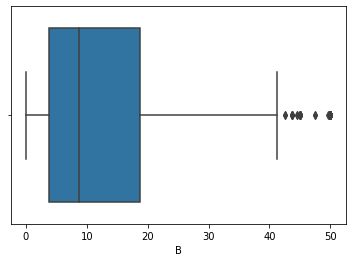

In [22]:
#test
test_df = remove_outliers(base_tv_clean,'B')
sns.boxplot(test_df['B'])

In [23]:
# function to remove outliers from a given array
def remove_outliers_a(array):
    Q1 = np.percentile(array,25)
    Q3 = np.percentile(array,75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    array_noout = array[(array>(Q1-IQR*1.5))&(array<(Q3+IQR*1.5))]
    return array_noout

In [24]:
# test removing outliers on a part of the dataframe 
# group df by curency
base_tv_filled_gr = base_tv_clean.groupby(by='symbol')
gr_usd = base_tv_filled_gr.get_group('$')

In [25]:
# check how many outliers are present in each separate column
cols = ['A','B','C','D','E']
for c in cols:
    no_out = remove_outliers(gr_usd, c)
    print("Removing outliers from col",c, "removes", len(gr_usd)- len(no_out), "rows.")

Removing outliers from col A removes 803 rows.
Removing outliers from col B removes 775 rows.
Removing outliers from col C removes 790 rows.
Removing outliers from col D removes 1123 rows.
Removing outliers from col E removes 968 rows.


We could remove outliers from each column creating a new dataframe, and then merge all resulting dataframes. This however would create many duplicate rows. 

In [26]:
lens = []
for c in cols:
    no_out = remove_outliers(base_tv_clean, c)
    lens.append(len(no_out))
    print(f'''Removing outliers from col {c} removes {len(base_tv_clean)- len(no_out)} rows
    and leaves us with {len(no_out)} rows''')

print("If we merge them all without removing duplicates we'll get a df with", sum(lens), "rows.")

Removing outliers from col A removes 1089 rows
    and leaves us with 12707 rows
Removing outliers from col B removes 1040 rows
    and leaves us with 12756 rows
Removing outliers from col C removes 1106 rows
    and leaves us with 12690 rows
Removing outliers from col D removes 1530 rows
    and leaves us with 12266 rows
Removing outliers from col E removes 1274 rows
    and leaves us with 12522 rows
If we merge them all without removing duplicates we'll get a df with 62941 rows.


In [27]:
print("If we remove all the outliers & duplicates we should expect around", len(base_tv_clean) - 1574, "rows.")

If we remove all the outliers & duplicates we should expect around 12222 rows.


Given the values in columns A-E are input in differnt currencies, we can only remove outliers for each currency group separately. 

In [28]:
#create an empty df to which we append cleaned grouped dataframes
base_tv_removed = pd.DataFrame(columns=base_tv_clean.columns)

for currency in base_tv_clean['symbol'].value_counts().index:
    #group by symbol
    base_tv_filled_gr = base_tv_clean.groupby(by='symbol')
    #get the group for each unique currency
    grouped = base_tv_filled_gr.get_group(currency)
    
    #create a df to hold the grouped currency with duplicated rows
    base_w_duplicates = pd.DataFrame(columns=base_tv_clean.columns)
    #specify the columns to clean
    cols = ['A','B','C','D','E']
    for c in cols:
        #apply the function that removes outliers from each column
        grouped_no_out = remove_outliers(grouped, c)
        #append resulting df to the intermediary df
        base_w_duplicates = base_w_duplicates.append(grouped_no_out, ignore_index=True)
    #remove duplicated rows from the currency group
    print(len(base_w_duplicates))
    base_tv_no_dup = base_w_duplicates.drop_duplicates(ignore_index=True)
    print(len(base_tv_no_dup))
    #append the currency group to the main df
    base_tv_removed = base_tv_removed.append(base_tv_no_dup, ignore_index=True)
    print(len(base_tv_removed))

48046
10213
10213
8637
1855
12068
4702
1008
13076
1009
221
13297
672
153
13450
116
25
13475


In [29]:
# check for duplicates
base_tv_removed.duplicated().sum()

0

In [30]:
print("This process removed", len(base_tv_clean) - len(base_tv_removed), "rows. Resulting in", len(base_tv_removed), "rows.")

This process removed 321 rows. Resulting in 13475 rows.


This is not the number I expected, which suggests something could have gone wrong.

**As a result** we stil should have a dataframe with no missing values, and no outliers. 

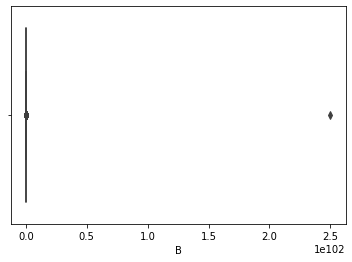

In [31]:
#check for outliers
sns.boxplot(base_tv_removed['B'])

Clearly something is wrong here. We'll remove outliers from each currncy group and column in a different way.

## Difference between employed & unemployed
Of the the questions the Value of Time tool was about the respondent's employment status. It'll be interesting to check whethere there is a significant difference in how employed and unemployed people value their time.

We'll do it for each currency first, and then for the whole dataframe.

We could convert all values into international dollar and remove outliers from the overall, but that could remove disproportional numbers of values from currencies used in locations where the pay is much lower. 

### USD

In [32]:
currency_grouped = base_tv_removed.groupby(by='symbol')
currency_usd = currency_grouped.get_group('$')
currency_usd.shape 

(10213, 23)

In [33]:
# remove outliers from each column
# doing a loop here didn't work, hence this ugly code for which i deeply apologize
currency_usd_noout = remove_outliers(currency_usd,column = 'E')
currency_usd_noout = remove_outliers(currency_usd_noout,column = 'B')
currency_usd_noout = remove_outliers(currency_usd_noout,column = 'A')
currency_usd_noout = remove_outliers(currency_usd_noout,column = 'C')
currency_usd_noout = remove_outliers(currency_usd_noout,column = 'D')
currency_usd_noout.shape

(7441, 23)

In [34]:
print("The number of outliers removed is", currency_usd.shape[0]-currency_usd_noout.shape[0])

The number of outliers removed is 2772


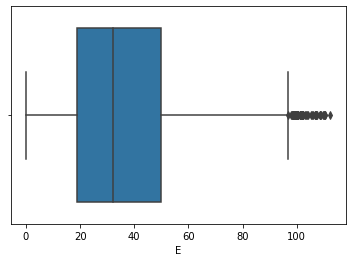

In [35]:
sns.boxplot(x=currency_usd_noout['E'])

In [36]:
# group the USD datafram by employment
currency_usd_noout_emp = currency_usd_noout.groupby('employment')

# mean values for groups
curency_usd_emp_m = currency_usd_noout_emp.mean()
curency_usd_emp_m[['A','B','C','D', 'E']]

,A,B,C,D,E
employment,,,,,
0,29.575375,8.385201,110.328045,13.168742,21.707228
1,41.612058,12.910193,130.273823,40.084815,40.151041


In [37]:
# variance values for groups
curency_usd_emp_v = currency_usd_noout_emp.var()
curency_usd_emp_v[['A','B','C','D', 'E']]

,A,B,C,D,E
employment,,,,,
0,658.717101,97.280279,7817.742600,207.778633,235.283042
1,744.237306,132.268063,8764.022535,771.713890,492.209439


**Statistical difference**
To assess whether there are statistically significant differneces between any of the values in columns A to E, between the employed and unemployed population we'll use Welch's t-test (unequal population size & unequal variance).

Hypothesis: There is no difference between the means between the employed and unemployed for any of the cols A-E.

* _mean.A for employed - mean.A unemployed  =0_

In [38]:
cols = ['A','B', 'C', 'D', 'E']

#create a dictionary to hold pvalues
p_vals_usd = {}

for c in cols:
    unemployed_c = currency_usd_noout_emp.get_group(0)[c]
    employed_c = currency_usd_noout_emp.get_group(1)[c]
    
    t_test = stats.ttest_ind(unemployed_c, employed_c, equal_var = False)
    p_val = t_test[1]
    p_vals_usd[c] = p_val

In [39]:
p_vals_usd

{'A': 9.051443864039993e-54,
 'B': 8.289276130923991e-50,
 'C': 3.4577701204083277e-14,
 'D': 0.0,
 'E': 1.531354307393106e-252}

In [40]:
float_formatter = lambda x: "%.10f" % x
for c in cols:
    if p_vals_usd[c] <= 0.05:
        pval = float_formatter(p_vals_usd[c])
        print('There is a significant difference between the employed and unemployed groups as it comes to column', c,'with a p value of',pval,'.' )
    else:
        print("There are no significan't differences.")

There is a significant difference between the employed and unemployed groups as it comes to column A with a p value of 0.0000000000 .
There is a significant difference between the employed and unemployed groups as it comes to column B with a p value of 0.0000000000 .
There is a significant difference between the employed and unemployed groups as it comes to column C with a p value of 0.0000000000 .
There is a significant difference between the employed and unemployed groups as it comes to column D with a p value of 0.0000000000 .
There is a significant difference between the employed and unemployed groups as it comes to column E with a p value of 0.0000000000 .


## Other currencies
We'll repeat the same process for each currency. 

It will be useful to convert the values into international dollar **after** outliers from each separate currency group are removed, to have a better picture of the whole distribution. 

In [41]:
# pounds 
currency_gbp = currency_grouped.get_group('GBP')
currency_gbp.shape

(1008, 23)

In [42]:
# remove outliers from each column
currency_gbp_noout = remove_outliers(currency_gbp,column = 'E')
currency_gbp_noout = remove_outliers(currency_gbp_noout,column = 'B')
currency_gbp_noout = remove_outliers(currency_gbp_noout,column = 'A')
currency_gbp_noout = remove_outliers(currency_gbp_noout,column = 'C')
currency_gbp_noout = remove_outliers(currency_gbp_noout,column = 'D')
currency_gbp_noout.shape

(774, 23)

In [43]:
print("The number of outliers removed is", currency_gbp.shape[0]-currency_gbp_noout.shape[0])

The number of outliers removed is 234


In [44]:
currency_rub = currency_grouped.get_group('RUB')
currency_rub.shape

(25, 23)

In [45]:
# remove outliers from each column
currency_rub_noout = remove_outliers(currency_rub,column = 'E')
currency_rub_noout = remove_outliers(currency_rub_noout,column = 'B')
currency_rub_noout = remove_outliers(currency_rub_noout,column = 'A')
currency_rub_noout = remove_outliers(currency_rub_noout,column = 'C')
currency_rub_noout = remove_outliers(currency_rub_noout,column = 'D')
print(currency_rub_noout.shape)

print("The number of outliers removed in Rubles group is", currency_rub.shape[0]-currency_rub_noout.shape[0])

(20, 23)
The number of outliers removed in Rubles group is 5


In [46]:
# euros
currency_eur = currency_grouped.get_group("EUR")
currency_eur.shape

(1855, 23)

In [47]:
# remove outliers from each column
currency_eur_noout = remove_outliers(currency_eur,column = 'E')
currency_eur_noout = remove_outliers(currency_eur_noout,column = 'B')
currency_eur_noout = remove_outliers(currency_eur_noout,column = 'A')
currency_eur_noout = remove_outliers(currency_eur_noout,column = 'C')
currency_eur_noout = remove_outliers(currency_eur_noout,column = 'D')
print(currency_eur_noout.shape)

print("The number of outliers removed in EUR grouo is", currency_eur.shape[0]-currency_eur_noout.shape[0])

(1415, 23)
The number of outliers removed in EUR grouo is 440


In [48]:
# INR
currency_inr = currency_grouped.get_group("INR")
currency_inr.shape

(153, 23)

In [49]:
# remove outliers from each column
currency_inr_noout = remove_outliers(currency_inr,column = 'E')
currency_inr_noout = remove_outliers(currency_inr_noout,column = 'B')
currency_inr_noout = remove_outliers(currency_inr_noout,column = 'A')
currency_inr_noout = remove_outliers(currency_inr_noout,column = 'C')
currency_inr_noout = remove_outliers(currency_inr_noout,column = 'D')
print(currency_inr_noout.shape)

print("The number of outliers removed in the Rupee group is", currency_inr.shape[0]-currency_inr_noout.shape[0])

(89, 23)
The number of outliers removed in the Rupee group is 64


In [50]:
# NIS
currency_nis = currency_grouped.get_group("NIS")
currency_nis.shape

(221, 23)

In [51]:
# remove outliers from each column
currency_nis_noout = remove_outliers(currency_nis,column = 'E')
currency_nis_noout = remove_outliers(currency_nis_noout,column = 'B')
currency_nis_noout = remove_outliers(currency_nis_noout,column = 'A')
currency_nis_noout = remove_outliers(currency_nis_noout,column = 'C')
currency_nis_noout = remove_outliers(currency_nis_noout,column = 'D')
print(currency_inr_noout.shape)

print("The number of outliers removed in the Shekel group is", currency_nis.shape[0]-currency_nis_noout.shape[0])

(89, 23)
The number of outliers removed in the Shekel group is 72


In [52]:
# join all dfs with no outliers
dfs = [currency_gbp_noout, currency_nis_noout, currency_rub_noout, currency_eur_noout, currency_inr_noout]

basetv_noout = currency_usd_noout.append(dfs)
print("In total this process removed", base_tv_clean.shape[0] - basetv_noout.shape[0], "rows. The new df has", basetv_noout.shape[0], "rows.")

In total this process removed 3908 rows. The new df has 9888 rows.


In [53]:
basetv_noout.to_csv("CT_no_outliers.csv")

In [54]:
# mean values for each question grouped by currency and employment
currencies_employment_gr = basetv_noout.groupby(['symbol', 'employment'])
currencies_employment_gr_mean = currencies_employment_gr.mean()
currencies_employment_gr_mean[cols]

A           B            C            D  \
symbol employment                                                      
$      0             29.575375    8.385201   110.328045    13.168742   
       1             41.612058   12.910193   130.273823    40.084815   
EUR    0             24.526613    5.249597   102.789493     9.253360   
       1             31.929441    7.266289   120.870828    23.872342   
GBP    0             18.534641    5.379085    90.262297     9.424902   
       1             24.597617    7.526059   104.249985    21.833649   
INR    0            466.818182   78.162879   296.533517   150.666667   
       1            564.375000  115.147321   375.187075   630.204566   
NIS    0            104.157895   19.605263   211.387560    40.210526   
       1            135.230769   29.704615   254.910256   104.167855   
RUB    0            640.750000   68.093750   642.295455   112.625000   
       1           1459.333333  551.250000  1162.500000  1091.633857   

                             E  
symbol employment               
$      0             21.707228  
       1             40.151041  
EUR    0             17.019216  
       1             27.646145  
GBP    0             14.502342  
       1             23.265459  
INR    0            188.728880  
       1            385.197445  
NIS    0             67.359649  
       1            114.600515  
RUB    0            206.500000  
       1           1020.675903

In [55]:
# variance for each question grouped by currency and employment
currencies_employment_gr_var = currencies_employment_gr.var()
currencies_employment_gr_var[cols]

A              B             C              D  \
symbol employment                                                             
$      0           6.587171e+02      97.280279  7.817743e+03     207.778633   
       1           7.442373e+02     132.268063  8.764023e+03     771.713890   
EUR    0           4.421658e+02      34.862159  9.112387e+03      83.854942   
       1           5.276709e+02      41.284598  9.096905e+03     225.026560   
GBP    0           1.611862e+02      27.290382  6.651154e+03      86.530903   
       1           1.877411e+02      42.391297  6.661119e+03     158.971247   
INR    0           1.627255e+05    5623.170395  3.117306e+04   32386.104167   
       1           2.264500e+05   14738.404038  3.436386e+04  202629.603713   
NIS    0           4.921251e+03     622.620249  1.264242e+04    1039.730994   
       1           4.927078e+03     468.511955  2.418046e+04    4666.123983   
RUB    0           1.388539e+06    8873.713170  1.056222e+06   17415.696429   
       1           1.115845e+06  295615.340909  8.468750e+05  529890.613898   

                               E  
symbol employment                 
$      0              235.283042  
       1              492.209439  
EUR    0              156.746050  
       1              239.534373  
GBP    0               76.590847  
       1              111.657149  
INR    0             9715.891614  
       1            55713.863739  
NIS    0             1700.374269  
       1             2415.639652  
RUB    0            68697.303571  
       1           477786.410072

In [56]:
# how to get a group
currencies_employment_gr.get_group(('$',0))

,employment,wageorsalary,symbol,choseOtherCurrency,currentwage,A,B,C,E,hoursweekly,...,D,hourminimum,jobnumber,weeklywage,jobask,totalweeks,totalhoursyearly,totalannualwage,transferquestion,jobtotal
7,0,0,$,0,0.0,32.0,15.00,40.000000,26.000000,0.0,...,20.0,0.0,0.0,0.0,0,0,0.0,0.0,no,0
8,0,0,$,0,0.0,50.0,50.00,120.000000,50.000000,0.0,...,19.0,0.0,0.0,0.0,0,0,0.0,0.0,no,0
38,0,0,$,0,0.0,18.0,10.00,50.000000,14.000000,0.0,...,8.0,0.0,0.0,0.0,0,0,0.0,0.0,no,0
47,0,0,$,0,0.0,7.5,6.25,50.000000,16.250000,0.0,...,25.0,0.0,0.0,0.0,0,0,0.0,0.0,no,0
98,0,0,$,0,0.0,15.0,7.50,100.000000,12.500000,0.0,...,10.0,0.0,0.0,0.0,0,0,0.0,0.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9511,0,0,$,0,0.0,50.0,5.00,33.333333,21.666667,0.0,...,10.0,0.0,0.0,0.0,0,0,0.0,0.0,no,0
9513,0,0,$,0,0.0,15.0,10.00,133.333333,17.500000,0.0,...,20.0,0.0,0.0,0.0,0,0,0.0,0.0,no,0
9514,0,0,$,0,0.0,28.0,3.75,85.714286,19.000000,0.0,...,10.0,0.0,0.0,0.0,0,0,0.0,0.0,no,0
9520,0,0,$,0,0.0,16.0,18.75,33.333333,19.375000,0.0,...,20.0,0.0,0.0,0.0,0,0,0.0,0.0,no,0


## Standardizing currencies

Converting other currencies into international dollar for a more accurate comparison.
Values from [OECD data, 2019](https://data.oecd.org/conversion/exchange-rates.htm#indicator-chart)

* 1 USD = GBP 0.680
* 1 USD = INR 21.107
* 1 USD = NIS 3.687
* 1 USD = EUR 0.706 (value for all 19 countries using EUR)
* 1 USD = RUB 25.701

To convert to dollars we'll divide the value in cols A-E by the value above.

In [57]:
#create cols to hold normalised currencies
cols_normed = ['A_dol','B_dol','C_dol','D_dol','E_dol']

for c in cols_normed:
    basetv_noout[c] = 0

In [58]:
# create columns dictionary
col_dict = {cols[i]: cols_normed[i] for i in range(len(cols))}

for i in col_dict:
    print(i, col_dict[i])

A A_dol
B B_dol
C C_dol
D D_dol
E E_dol


In [59]:
# create currency dictionary
exchange = {'$': 1,'GBP':0.680,'INR':21.107,'NIS':3.687, 'EUR':0.706,'RUB':25.701}
for c in exchange:
    print(c, exchange[c])

$ 1
GBP 0.68
INR 21.107
NIS 3.687
EUR 0.706
RUB 25.701


In [60]:
# normalise all currencies
conditions = [
    (basetv_noout['symbol'] == 'GBP'),
    (basetv_noout['symbol'] == '$'),  
    (basetv_noout['symbol'] == 'INR'),
    (basetv_noout['symbol'] == 'NIS'),
    (basetv_noout['symbol'] == 'EUR'),
    (basetv_noout['symbol'] == 'RUB')
]

for i in col_dict:
    choices = [basetv_noout[i]/0.68, basetv_noout[i]/1, basetv_noout[i]/21.107, basetv_noout[i]/3.687, basetv_noout[i]/0.706, basetv_noout[i]/25.701]
    new_col = col_dict[i]
    basetv_noout[new_col] = np.select(conditions, choices, default=0)

In [61]:
#test 
basetv_noout[basetv_noout['symbol']=='INR'][cols_normed].head()

,A_dol,B_dol,C_dol,D_dol,E_dol
13297,33.164353,4.737765,28.426588,66.052362,30.795471
13298,23.688824,11.844412,28.426588,42.583227,26.057706
13302,47.377647,5.922206,28.426588,61.117165,37.902118
13303,23.688824,3.553324,18.951059,14.213294,16.582177
13305,0.331644,0.082911,40.609412,0.331644,0.331644


In [62]:
basetv_noout = basetv_noout[basetv_noout['totalhoursyearly'] < 25000]

In [63]:
# will export A-E converted but not wage per year
basetv_noout.to_excel('CT_base_no_out.xlsx')

### Mean values, by employment across the dataset

In [64]:
# convert all normed columns into floats
basetv_noout[cols_normed]= basetv_noout[cols_normed].astype('float64')

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [65]:
# plot differences overall by column
total_employment = basetv_noout.groupby('employment')
total_employment_means = total_employment.mean()[cols_normed]
total_employment_count = total_employment.count()[cols_normed]
total_employment_means.reset_index(inplace=True)

In [66]:
# print means of all values
total_employment_means

,employment,A_dol,B_dol,C_dol,D_dol,E_dol
0,0,30.192101,8.049642,116.054037,13.056208,21.824091
1,1,41.502517,12.297488,135.602946,38.359717,39.247173


In [67]:
# show number of samples in each group
total_employment_count

,A_dol,B_dol,C_dol,D_dol,E_dol
employment,,,,,
0,2040,2040,2040,2040,2040
1,7847,7847,7847,7847,7847


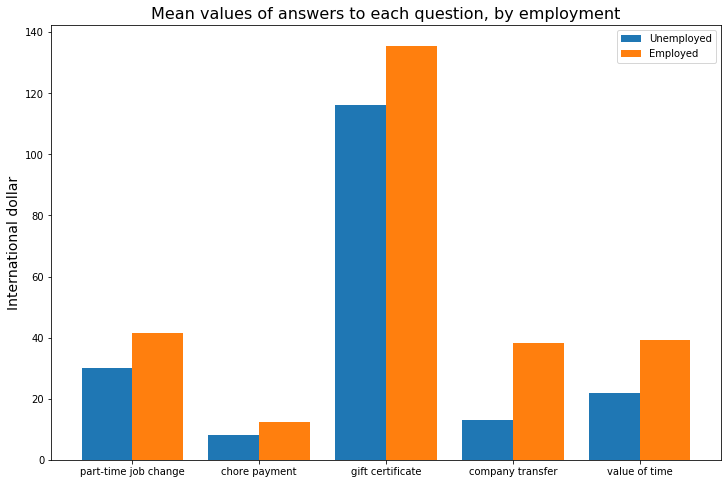

In [68]:
# plot means across the dataset
fig, ax = plt.subplots(figsize=(12,8))
labels = ['part-time job change',  'chore payment', 'gift certificate',  'company transfer', 'value of time']
x = np.arange(len(labels))
width=0.4

_ = ax.bar(x, total_employment_means[cols_normed].iloc[0], width=width, label="Unemployed")
_ = ax.bar(x+width, total_employment_means[cols_normed].iloc[1],width=width, label="Employed")

ax.set_xticks(x+width/2)
ax.set_xticklabels(labels)
ax.set_ylabel("International dollar", fontsize=14)

plt.legend()
plt.title("Mean values of answers to each question, by employment", fontsize=16)

plt.show()

There are clear diffrences between values given by employed an unemployed. We can test the significance with a t-test.

In [69]:
#create a dictionary for pvalues
p_vals_total = {}

# iterate through columns, calc p value between employed and unemployed for each column
for c in cols_normed:
    unemployed_c = total_employment.get_group(0)[c]
    employed_c = total_employment.get_group(1)[c]
    
    t_test = stats.ttest_ind(unemployed_c, employed_c, equal_var = False)
    p_val = t_test[1]
    p_vals_total[c] = p_val

In [70]:
p_vals_total

{'A_dol': 5.66416644255204e-64,
 'B_dol': 3.0650409053106936e-66,
 'C_dol': 2.0205523420407214e-14,
 'D_dol': 0.0,
 'E_dol': 0.0}

pvalue = 0 seems a suspicious result. Can it be so small Python doesn't even bother to write it in the scientific notation?

In [71]:
#check max float value
import sys
print("Float value information: ",sys.float_info)

Float value information:  sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


The value would have to be smaller than 1.7976931348623157e+308, which seems ahighly unlikely. More likely there is an error somewhere, but I can't see where.

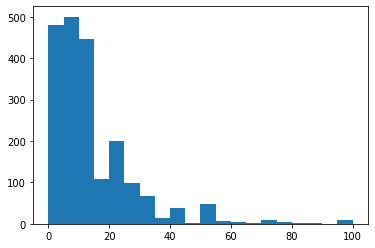

In [72]:
# check distribution of col D to see if anything weird appears
unemp_dol = total_employment.get_group(0)['D_dol']
_ = plt.hist(unemp_dol, bins=20)

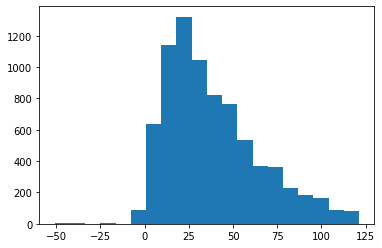

In [73]:
# check distribution
unemp_dol = total_employment.get_group(1)['D_dol']
_ = plt.hist(unemp_dol, bins=20)

### Mean values, by employment by each currency group

In [74]:
#dropping the russian respondents
basetv_noout_norus = basetv_noout[basetv_noout['symbol']!='RUB']

In [75]:
# group df by currency and employment for the no rus group
ppp_employment_gr = basetv_noout.groupby(['symbol','employment'])
# create a view of sample sizes
ppp_employment_gr_count = basetv_noout.groupby(['symbol','employment']).count()
# get mean values for each columns
ppp_employment_gr_mean = ppp_employment_gr.mean()

#pick normalised columns to display
ppp_employment_means = ppp_employment_gr_mean[cols_normed]
ppp_employment_means

A_dol      B_dol       C_dol      D_dol      E_dol
symbol employment                                                        
$      0           29.575375   8.385201  110.328045  13.168742  21.707228
       1           41.612058  12.910193  130.273823  40.084815  40.151041
EUR    0           34.740245   7.435689  145.594183  13.106743  24.106539
       1           45.225837  10.292194  171.205139  33.813515  39.158845
GBP    0           27.256824   7.910419  132.738672  13.860150  21.326974
       1           36.172966  11.067733  153.308801  32.108307  34.213910
INR    0           22.116747   3.703173   14.049060   7.138232   8.941530
       1           27.218889   5.553091   17.360318  30.394445  18.575532
NIS    0           28.250039   5.317403   57.333214  10.906028  18.269501
       1           36.677724   8.056581   69.137580  28.252741  31.082320
RUB    0           24.930937   2.649459   24.991069   4.382125   8.034707
       1           56.781189  21.448582   45.231703  42.474373  39.713470

In [76]:
# group df by currency and employment for the no rus group
ppp_employment_gr_norus = basetv_noout_norus.groupby(['symbol','employment'])
# create a view of sample sizes
ppp_employment_gr_count_norus = basetv_noout_norus.groupby(['symbol','employment']).count()
# get mean values for each columns
ppp_employment_gr_mean_norus = ppp_employment_gr_norus.mean()

#pick normalised columns to display
ppp_employment_means_norus = ppp_employment_gr_mean_norus[cols_normed]
ppp_employment_means_norus.reset_index(inplace=True)
ppp_employment_means_norus

,symbol,employment,A_dol,B_dol,C_dol,D_dol,E_dol
0,$,0,29.575375,8.385201,110.328045,13.168742,21.707228
1,$,1,41.612058,12.910193,130.273823,40.084815,40.151041
2,EUR,0,34.740245,7.435689,145.594183,13.106743,24.106539
3,EUR,1,45.225837,10.292194,171.205139,33.813515,39.158845
4,GBP,0,27.256824,7.910419,132.738672,13.860150,21.326974
5,GBP,1,36.172966,11.067733,153.308801,32.108307,34.213910
6,INR,0,22.116747,3.703173,14.049060,7.138232,8.941530
7,INR,1,27.218889,5.553091,17.360318,30.394445,18.575532
8,NIS,0,28.250039,5.317403,57.333214,10.906028,18.269501
9,NIS,1,36.677724,8.056581,69.137580,28.252741,31.082320


In [77]:
# trasform the both of the above dfs for easier plotting
ppp_employment_means.reset_index(inplace=True)
ppp_e = ppp_employment_means[['symbol','employment','E_dol']]

ppp_employment_means_norus.reset_index(inplace=True)
ppp_e_norus = ppp_employment_means_norus[['symbol','employment','E_dol']]
ppp_e_norus

,symbol,employment,E_dol
0,$,0,21.707228
1,$,1,40.151041
2,EUR,0,24.106539
3,EUR,1,39.158845
4,GBP,0,21.326974
5,GBP,1,34.213910
6,INR,0,8.941530
7,INR,1,18.575532
8,NIS,0,18.269501
9,NIS,1,31.082320


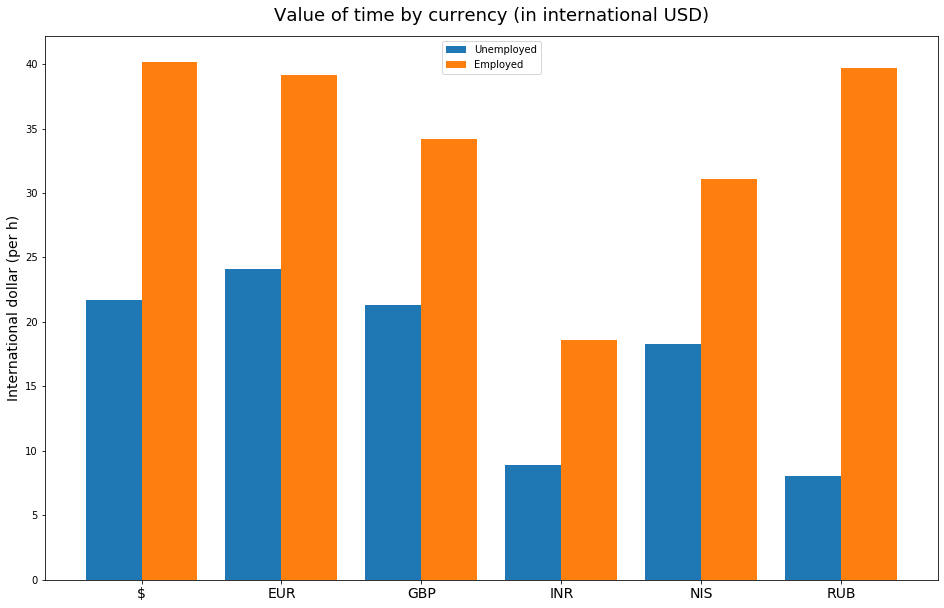

In [78]:
fig, ax = plt.subplots(figsize=(16,10))

labels = ppp_e['symbol'].unique()

x = np.arange(len(labels))
bar_width = 0.4

g1 = ppp_e.loc[ppp_e['employment'] == 1, 'E_dol']
g2 = ppp_e.loc[ppp_e['employment'] == 0, 'E_dol']

_ = ax.bar(x, g2, width=bar_width, label='Unemployed',)
_ = ax.bar(x+bar_width, g1, width=bar_width, label='Employed')

ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(labels, fontsize=14)
ax.set_ylabel("International dollar (per h)", fontsize=14)
ax.set_title('Value of time by currency (in international USD)', pad=15, fontsize=18)
ax.legend()

plt.show()

fig.tight_layout()

### Statistical significance

**1. In each currency group**

We can check if the differnces between means for employed and unemployed groups for each curency, are statistically significant using a t-test. 

In [79]:
#create a dictionary to hold pvalues
p_vals_e_dol = {}

for l in labels:
    unemployed_c = ppp_employment_gr.get_group((l,0))['E_dol']
    employed_c = ppp_employment_gr.get_group((l,1))['E_dol']
    
    t_test = stats.ttest_ind(unemployed_c, employed_c, equal_var = False)
    p_val = t_test[1]
    p_vals_e_dol[l] = p_val

In [80]:
p_vals_e_dol

{'$': 1.531354307393106e-252,
 'EUR': 5.3193985024449094e-36,
 'GBP': 2.780992364005684e-22,
 'INR': 2.0566192592612348e-07,
 'NIS': 0.00011113510856142686,
 'RUB': 0.0021043547622718716}

**Resut**: In each currency group the differences between employed and unemployed are statistically significant.

In [81]:
ppp_employment_gr_count[cols_normed]

A_dol  B_dol  C_dol  D_dol  E_dol
symbol employment                                   
$      0            1455   1455   1455   1455   1455
       1            5986   5986   5986   5986   5986
EUR    0             372    372    372    372    372
       1            1043   1043   1043   1043   1043
GBP    0             153    153    153    153    153
       1             621    621    621    621    621
INR    0              33     33     33     33     33
       1              55     55     55     55     55
NIS    0              19     19     19     19     19
       1             130    130    130    130    130
RUB    0               8      8      8      8      8
       1              12     12     12     12     12

**2. For each employment status between currency groups**

We can also check for significance between pairsof currencies for the same employment status. 
E.g. _Is the difference in means between employed USD earners and NIS earners statistically significant?_

We'll start by comparing employed USD earners with employed earners from other currency groups.

In [82]:
# compare employed
p_vals_dol_vs_other = {}

for l in labels:
    employed_usd = ppp_employment_gr.get_group(('$',1))['E_dol']
    employed_c = ppp_employment_gr.get_group((l,1))['E_dol']
    
    t_test = stats.ttest_ind(employed_usd, employed_c, equal_var = False)
    p_val = t_test[1]
    p_vals_dol_vs_other[l] = p_val

In [83]:
p_vals_dol_vs_other

{'$': 1.0,
 'EUR': 0.1783566739793286,
 'GBP': 2.312277951123838e-17,
 'INR': 1.2296979154547727e-20,
 'NIS': 4.884867230344845e-12,
 'RUB': 0.9560927995767583}

The difference is significant between employed USD earners and GBP, INR, and NIS earners. Not significant for EUR and RUB.

In [84]:
# function to check differeneces between each currency pair with regards to a given column
# input column name, output dictionary of dictionaries

def check_un_employment_pvals(column):
    p_val_dict = {}

    # iterate through all currencies
    for l in labels:
        p_vals_one_vs_other = {}

        # create a currency group to compare other currencies to
        employed_c1 = ppp_employment_gr.get_group((l,1))[column]

        # iterate through all currencies again
        for w in labels:
            #create a compariosn group
            employed_c = ppp_employment_gr.get_group((w,1))[column]

            #run t test between each pair
            t_test = stats.ttest_ind(employed_c1, employed_c, equal_var = False)

            #extract the pvalue and add to a dictionary
            p_val = t_test[1]
            p_vals_one_vs_other[w] = p_val
        # add the resulting currency dictionay to the master dictionary
        p_val_dict[l] = p_vals_one_vs_other 
    return p_val_dict

In [85]:
p_val_dict = check_un_employment_pvals('E_dol')

In [86]:
for item in p_val_dict:
    sub_dict = p_val_dict[item]
    for c in sub_dict:
        if sub_dict[c] < 0.05:
            print("There is a significant difference in means between", item, "and", c, "with a p-value of", sub_dict[c])
        if (sub_dict[c] >= 0.05) & (sub_dict[c] < 1):
            print("There is NO significant difference in means between", item, "and", c, "with a p-value of", sub_dict[c])

There is NO significant difference in means between $ and EUR with a p-value of 0.1783566739793286
There is a significant difference in means between $ and GBP with a p-value of 2.312277951123838e-17
There is a significant difference in means between $ and INR with a p-value of 1.2296979154547727e-20
There is a significant difference in means between $ and NIS with a p-value of 4.884867230344845e-12
There is NO significant difference in means between $ and RUB with a p-value of 0.9560927995767583
There is NO significant difference in means between EUR and $ with a p-value of 0.1783566739793286
There is a significant difference in means between EUR and GBP with a p-value of 9.281964171145644e-08
There is a significant difference in means between EUR and INR with a p-value of 1.418999265144762e-20
There is a significant difference in means between EUR and NIS with a p-value of 8.843538850410348e-09
There is NO significant difference in means between EUR and RUB with a p-value of 0.944524

**Conclusion**
Differences between employed Ruble earners and all other currencies, except rupees, weren’t statistically significant. This might be true, but we also need to bear in mind the sample for RUB was really small (below 20). Afaiu the Welch's t-test doesn’t need same sample sizes or variances, but still comparing a sample of ~8k to a sample of ~20 is bound to be somewhat unreliable. 

For all other pairs of currencies the differences were statistically significant, except for one, EUR and USD. This means while USD earners value their time slightly higher on average than EUR earners, the difference is not significant. 

## Mean value plots for each question by employment

In [87]:
def plot_means_by_employment_for_column(column):
    
    # filter the dataframe with means
    ppp = ppp_employment_means[['symbol','employment', column]]
    fig, ax = plt.subplots(figsize=(10,8))

    labels = ppp['symbol'].unique()

    x = np.arange(len(labels))
    bar_width = 0.4

    g1 = ppp.loc[ppp['employment'] == 1, column]
    g2 = ppp.loc[ppp['employment'] == 0, column]

    _ = ax.bar(x, g1, width=bar_width, label='Employed')
    _ = ax.bar(x+bar_width, g2, width=bar_width, label='Unemployed')
    
    title = f"Mean values for answers to question {column} by employment (in international dollars)"
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(labels, fontsize=14)
    ax.set_ylabel("International dollar")
    ax.set_title(title, pad=15, fontsize=16)
    ax.legend()

    plt.show()

    fig.tight_layout()

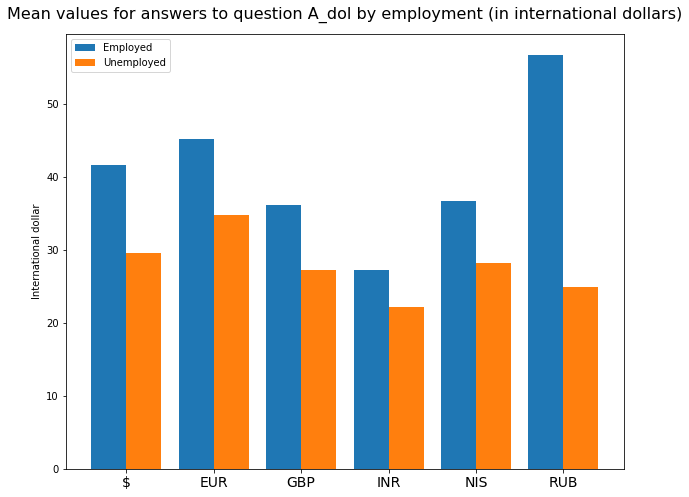

In [88]:
plot_means_by_employment_for_column('A_dol')

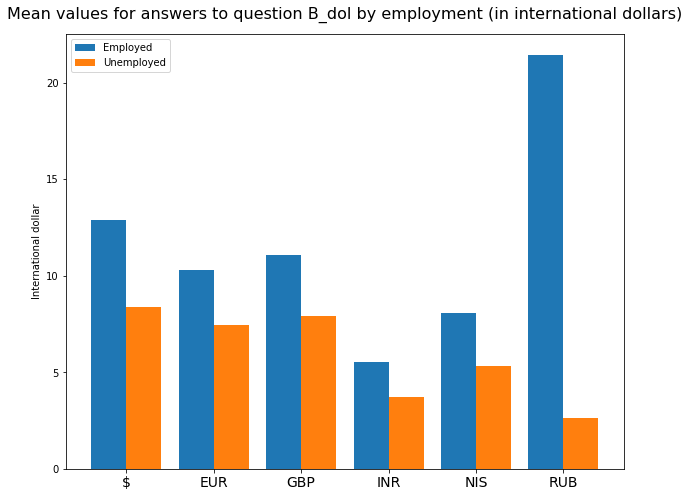

In [89]:
plot_means_by_employment_for_column('B_dol')

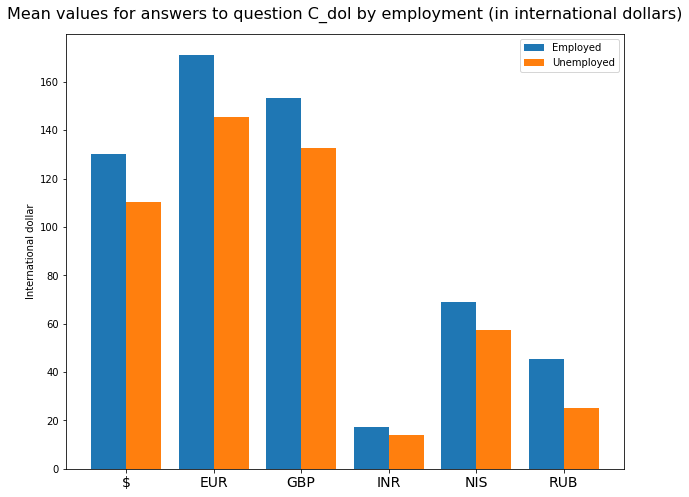

In [90]:
plot_means_by_employment_for_column('C_dol')

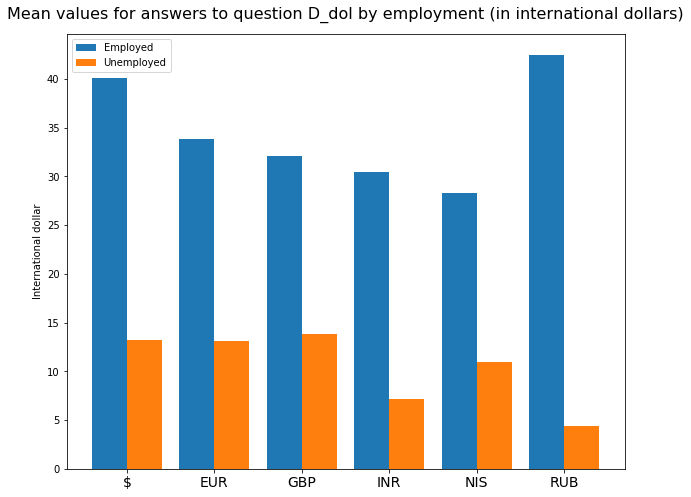

In [91]:
plot_means_by_employment_for_column('D_dol')

For each question the employed give higher values than the unemployed. We'll skip checking statistical significance, for each of them.

In [92]:
p_val_dict_A = check_un_employment_pvals('A_dol')

In [93]:
for item in p_val_dict_A:
    sub_dict = p_val_dict_A[item]
    for c in sub_dict:
        if sub_dict[c] < 0.05:
            print("There is a significant difference in means between", item, "and", c, "with a p-value of", sub_dict[c])
        if (sub_dict[c] >= 0.05) & (sub_dict[c] < 1):
            print("There is NO significant difference in means between", item, "and", c, "with a p-value of", sub_dict[c])

There is a significant difference in means between $ and EUR with a p-value of 0.0007312673480793661
There is a significant difference in means between $ and GBP with a p-value of 1.0690768581477404e-09
There is a significant difference in means between $ and INR with a p-value of 1.6407085175638627e-05
There is a significant difference in means between $ and NIS with a p-value of 0.004444757773226471
There is NO significant difference in means between $ and RUB with a p-value of 0.22753748154448508
There is a significant difference in means between EUR and $ with a p-value of 0.0007312673480793661
There is a significant difference in means between EUR and GBP with a p-value of 3.507351415867205e-12
There is a significant difference in means between EUR and INR with a p-value of 3.7437111578681685e-07
There is a significant difference in means between EUR and NIS with a p-value of 1.7597493661082296e-05
There is NO significant difference in means between EUR and RUB with a p-value of 0

## Correlations
We can calculate correlations between answers to each question, for the full dataframe. It will be interesting to see if the correlations are different for each currency group.

In [94]:
# create a base table for correlations
base_cols_for_correl = basetv_noout[['A_dol', 'B_dol', 'C_dol', 'D_dol', 'E_dol']]

#create a matrix & pick pairs
correl_matrix = base_cols_for_correl.corr()
correl_pairs = correl_matrix.unstack().sort_values() 

#pick values above 0.7 sinigficance threshold
f = (correl_pairs>0.7) & (correl_pairs<1)
large_positive_corr = correl_pairs[f]

print(f"For the whole dataframe there are strong correlations between the following columns: \n{large_positive_corr}")

For the whole dataframe there are strong correlations between the following columns: 
D_dol  E_dol    0.795097
E_dol  D_dol    0.795097
       A_dol    0.832753
A_dol  E_dol    0.832753
dtype: float64


In [95]:
overal_d_e_correl = large_positive_corr[0]
overal_a_e_correl = large_positive_corr[-1]
print("There is a strong positive correlation between columns D & E:",round(overal_d_e_correl,4)," and between A & E:",round(overal_a_e_correl,4))

There is a strong positive correlation between columns D & E: 0.7951  and between A & E: 0.8328


**Intrerpretation.**

To interpret we'll follow standard benchmarks where typically:
* values over 0.3 or under -0.3 are considered weak correlations
* values over 0.5 or under -0.5 are considered medium correlations
* values over 0.7 or under -0.7 are considered strong correlations


**Conclusion:**
It's expected there would be positive correlations between each question and the final value of time. The higher peole valued their time in each task/question, the higher it means they value it overall. 

It's interesting to notice some variables correlate with the final value of time more strongly than others. Namely,  answers to questions A and D. This suggests they are stronger predictors of the final value of time, an assumption we can test later by creating a model (fitting a linear regression).


### Chcking correlations between columns for each currency group

In [96]:
# funciton to check correlations given the currency
def check_correl(currency):
    # group the table by currency
    ppp_currency_gr = basetv_noout.groupby('symbol')
    
    # get the selected currency group
    ppp_currency_gr_selected = ppp_currency_gr.get_group(currency)

    # define a df with columns for correlation
    ppp_currency_gr_selected_cols = ppp_currency_gr_selected[['A_dol', 'B_dol', 'C_dol', 'D_dol', 'E_dol']]

    # create a correlation matrix
    corr_matrix = ppp_currency_gr_selected_cols.corr()
    corr_pairs = corr_matrix.unstack().sort_values()

    # create filter for strong correlations
    f = (corr_pairs>0.7) & (corr_pairs<1)
    large_positive_corr = corr_pairs[f]
    for each_tupple in large_positive_corr.index:
        if (each_tupple[0] =='D_dol') & (each_tupple[1] =='E_dol'):
            corr_d_e = large_positive_corr['D_dol']['E_dol']
            if corr_d_e < overal_d_e_correl:
                text = "is lower"
                number = round((overal_d_e_correl - corr_d_e),3)
            else:
                text = 'is higher'
                number = round((corr_d_e - overal_d_e_correl),3)
        else:
            print()
    print(f'''For {currency} there are strong correlations between the following columns: \n{large_positive_corr}
    \nThe correlation between columns D and E for {currency} {text} by around {number}
    than the overall correlation observed in the whole dataframe.''')
    return corr_matrix

In [97]:
# funciton to plot a correlatiton heat map depending on curency
def plot_correl_heatmap(currency):
    corr_matrix = check_correl(currency)
    #plot as heatmap
    fig = plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix, annot=True)
    plt.title(f"Correlation heatmap for {currency}", fontsize=14)
    plt.show()




For $ there are strong correlations between the following columns: 
D_dol  E_dol    0.807918
E_dol  D_dol    0.807918
       A_dol    0.829346
A_dol  E_dol    0.829346
dtype: float64
    
The correlation between columns D and E for $ is higher by around 0.013
    than the overall correlation observed in the whole dataframe.


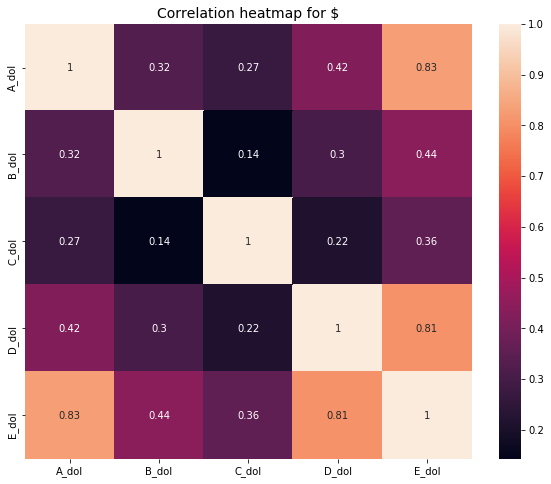

In [98]:
plot_correl_heatmap('$')

In [99]:
for l in labels:
    check_correl(l)




For $ there are strong correlations between the following columns: 
D_dol  E_dol    0.807918
E_dol  D_dol    0.807918
       A_dol    0.829346
A_dol  E_dol    0.829346
dtype: float64
    
The correlation between columns D and E for $ is higher by around 0.013
    than the overall correlation observed in the whole dataframe.



For EUR there are strong correlations between the following columns: 
D_dol  E_dol    0.736351
E_dol  D_dol    0.736351
       A_dol    0.878141
A_dol  E_dol    0.878141
dtype: float64
    
The correlation between columns D and E for EUR is lower by around 0.059
    than the overall correlation observed in the whole dataframe.



For GBP there are strong correlations between the following columns: 
D_dol  E_dol    0.788350
E_dol  D_dol    0.788350
       A_dol    0.830279
A_dol  E_dol    0.830279
dtype: float64
    
The correlation between columns D and E for GBP is lower by around 0.007
    than the overall correlation observed in the whole dataframe.



For 

**Conclusion**
Just like in the whole datafram, also for each currencies the answers to question D and A have the strongest positive corrlations with the final value of time. This suggests the answers to these questions have the highest impact on the final value of time. 

Rubles are a standout currency in that there are more strong positive correlations: answers to questions A, B, D (all apart from C) strongly correlate with the final value of time (E). In addition answers to questions B & D positively correate witheach other. We need to bear in mind that the sample size for rubles was very small (<50), so these results aren't reliable. 

## Value of time by enjoyment

Employed participants answered a question about the enjoyment they derive from work. We can check if there is an impact of enjoyment on how they value their time.

In [100]:
#create a base table
enjoyment = basetv_noout[['enjoy', 'employment','symbol','A_dol', 'B_dol', 'C_dol', 'D_dol', 'E_dol']]

#check values in enjoy column
enjoyment['enjoy'].value_counts(dropna=False)

Yes         3946
Somewhat    3321
0           2052
No           568
Name: enjoy, dtype: int64

There are over 2k values of zero where, presumably, the respondent didn't have a job ("employment" == 0).

In [101]:
# check how many had employment = 0
enjoyment["employment"].value_counts()

1    7847
0    2040
Name: employment, dtype: int64

In [102]:
enjoy_0 = enjoyment.loc[enjoyment['enjoy'] == 0]

In [103]:
en_emp = enjoyment.loc[(enjoyment["employment"] == 0) & (enjoyment["enjoy"] == 0)]
print("There are", en_emp.shape[0], "rows where both enjoyment and employment are 0. That leaves", enjoy_0.shape[0] - en_emp.shape[0], "rows where enjoyment is marked 0, even if the person is employed." )

There are 2039 rows where both enjoyment and employment are 0. That leaves 13 rows where enjoyment is marked 0, even if the person is employed.


We can safely remove all the rows where enjoyment was 0.

In [104]:
enjoyment_n0 = enjoyment.loc[enjoyment["enjoy"] != 0]

# separate frame to eliminate Russian responses
enjoyment_n0_norus = enjoyment_n0.loc[enjoyment_n0['symbol']!='RUB']

In [105]:
enjoyment_n0.head()

,enjoy,employment,symbol,A_dol,B_dol,C_dol,D_dol,E_dol
0,Somewhat,1,$,20.0,12.5,200.000000,20.000000,20.000000
2,Yes,1,$,30.0,12.5,50.000000,32.927350,31.463675
4,Yes,1,$,49.0,12.5,50.000000,101.923077,49.500000
5,Somewhat,1,$,75.0,20.0,100.000000,100.582333,87.500000
6,Yes,1,$,35.0,1.5,33.333333,19.500000,26.416667


We can get a feel for the values, and see if anyhtig immediately jumps out, by checking the distributions of each group.

In [106]:
levels = enjoyment_n0['enjoy'].unique()

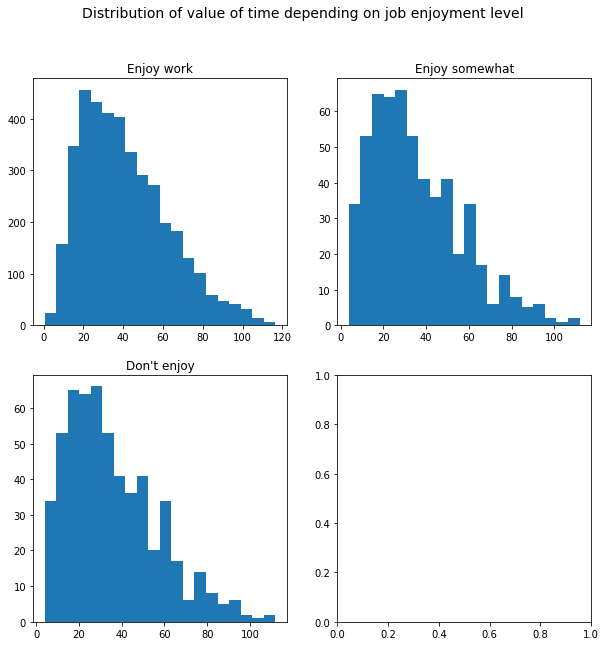

In [107]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

# define arays for plotting
y1 = enjoyment_n0.loc[enjoyment_n0['enjoy'] == 'Yes']['E_dol']
y2 = enjoyment_n0.loc[enjoyment_n0['enjoy'] == 'Somewhat']['E_dol']
y3 = enjoyment_n0.loc[enjoyment_n0['enjoy'] == 'No']['E_dol']

# one plot on each subplot
axes[0][0].hist(y1,bins=20)
axes[0][1].hist(y3,bins=20)
axes[1][0].hist(y3,bins= 20)

# set titles for each subplot
axes[0][0].set_title("Enjoy work")
axes[0][1].set_title("Enjoy somewhat")
axes[1][0].set_title("Don't enjoy")

#set main titles
plt.suptitle("Distribution of value of time depending on job enjoyment level", size=14)
plt.show()

Next, we can group by enjoyment levels and plot the means for each quesiton.

In [108]:
enjoyment_grouped = enjoyment_n0.groupby('enjoy')
enjoyment_grouped_mean = enjoyment_grouped.mean()

In [109]:
enjoyment_grouped_mean.reset_index(inplace=True)
enjoyment_grouped_mean

,enjoy,A_dol,B_dol,C_dol,D_dol,E_dol
0,No,36.007827,11.058119,126.088073,36.891815,35.698445
1,Somewhat,39.530704,11.694914,132.072474,37.462520,37.791349
2,Yes,43.982347,12.981455,140.073222,39.344731,41.004214


In [110]:
enjoyment_grouped_mean['enjoy'].values
cols_normed

['A_dol', 'B_dol', 'C_dol', 'D_dol', 'E_dol']

In [111]:
enjoyment_grouped_mean.set_index('enjoy',inplace=True)

In [112]:
enoyment_transposed = enjoyment_grouped_mean.transpose()

In [113]:
enoyment_transposed

enjoy,No,Somewhat,Yes
A_dol,36.007827,39.530704,43.982347
B_dol,11.058119,11.694914,12.981455
C_dol,126.088073,132.072474,140.073222
D_dol,36.891815,37.462520,39.344731
E_dol,35.698445,37.791349,41.004214


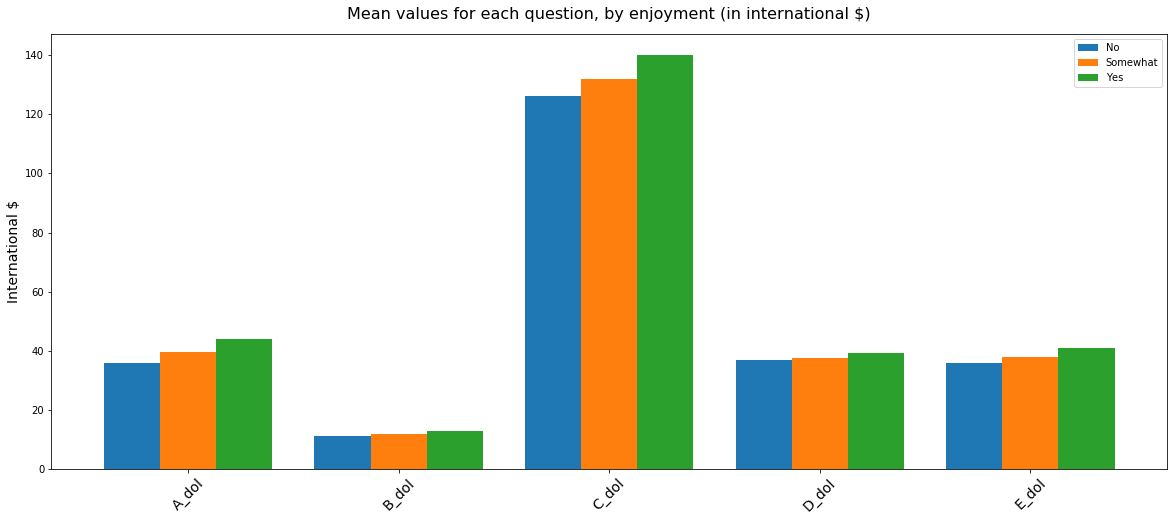

In [114]:
labels = cols_normed
x = np.arange(len(labels))
ax = enoyment_transposed.plot(kind='bar',figsize=(20, 8),width=0.8)

title = f"Mean values for each question, by enjoyment (in international $)"
ax.set_ylabel("International $", size=14)
ax.set_xticklabels(labels, fontsize=14, rotation=45)
ax.set_title(title, pad=15, fontsize=16)
ax.legend()

plt.show()

fig.tight_layout()

The diffrences in means between columns don't seem to be very different. That is, the value a person ataches to their free time doesn't depend much on the level of enjoyment they derive from work. We can make sure these results are statistically significant using Welch's t-test (assumes equal variance, unequal population sizes, tests hypothesis that the means are equal).

In [115]:
enjoyment_grouped_var = enjoyment_grouped.var()
enjoyment_grouped_var

,A_dol,B_dol,C_dol,D_dol,E_dol
enjoy,,,,,
No,666.415373,122.247244,10498.016052,747.795457,442.737329
Somewhat,700.421775,114.321061,10346.555432,673.202751,460.495636
Yes,808.356942,128.148370,10965.689434,706.622213,475.620846


In [116]:
#dictonary to hold p values
pvals_enjoy_yn = {}
pvals_enjoy_y_some = {}
pvals_enjoy_n_some = {}

#check pvalues between enjoyment yes & no in each question
for c in cols_normed:
    enjoy_yes_col = enjoyment_grouped.get_group('Yes')[c]
    enjoy_no_col = enjoyment_grouped.get_group('No')[c]
    enjoy_some_col = enjoyment_grouped.get_group('Somewhat')[c]
    
    enjoy_test_yn = stats.ttest_ind(enjoy_yes_col, enjoy_no_col)
    pval_yn = enjoy_test_yn[1]
    pvals_enjoy_yn[c] = pval_yn
    
    enjoy_test_y_some = stats.ttest_ind(enjoy_yes_col, enjoy_some_col)
    pval_y_some = enjoy_test_y_some[1]
    pvals_enjoy_y_some[c] = pval_y_some
    
    enjoy_test_n_some = stats.ttest_ind(enjoy_no_col, enjoy_some_col)
    pval_n_some = enjoy_test_n_some[1]
    pvals_enjoy_n_some[c] = pval_n_some

In [117]:
for v in pvals_enjoy_yn:
    if pvals_enjoy_yn[v] < 0.05:
        print("The differences in column", v, "are significant— p-value",round(pvals_enjoy_yn[v], 10), " (lower than 0.05)." )
    else:
        print("The differences in column", v, "are not significant — p-value",round(pvals_enjoy_yn[v], 2), "(higer than 0.05)." )

The differences in column A_dol are significant— p-value 3e-10  (lower than 0.05).
The differences in column B_dol are significant— p-value 0.000148434  (lower than 0.05).
The differences in column C_dol are significant— p-value 0.0028610107  (lower than 0.05).
The differences in column D_dol are significant— p-value 0.0405499926  (lower than 0.05).
The differences in column E_dol are significant— p-value 5.46e-08  (lower than 0.05).


**Conclusion**

Looks like eyeballing the chart didn't produce accurate results. There are significant differences in how people answer the questions (A-D) depending on how much they enjoy their work. This in turn produces significant diffrences in how they value their time.

People who enjoy their work value their time higher.

In [118]:
for v in pvals_enjoy_y_some:
    if pvals_enjoy_y_some[v] < 0.05:
        print("The differences in column", v, "are significant— p-value",round(pvals_enjoy_y_some[v], 10), " (lower than 0.05)." )
    else:
        print("The differences in column", v, "are not significant — p-value",round(pvals_enjoy_y_some[v], 2), "(higer than 0.05)." )

The differences in column A_dol are significant— p-value 0.0  (lower than 0.05).
The differences in column B_dol are significant— p-value 7.598e-07  (lower than 0.05).
The differences in column C_dol are significant— p-value 0.0010167423  (lower than 0.05).
The differences in column D_dol are significant— p-value 0.0023752539  (lower than 0.05).
The differences in column E_dol are significant— p-value 3e-10  (lower than 0.05).


Even those who only enjoy their work "somewhat" value their time significantly lower than those who enjoy their work.

In [119]:
for v in pvals_enjoy_n_some:
    if pvals_enjoy_n_some[v] < 0.05:
        print("The differences in column", v, "are significant— p-value",round(pvals_enjoy_n_some[v], 5), " (lower than 0.05)." )
    else:
        print("The differences in column", v, "are not significant — p-value",round(pvals_enjoy_n_some[v], 5), "(higer than 0.05)." )

The differences in column A_dol are significant— p-value 0.00328  (lower than 0.05).
The differences in column B_dol are not significant — p-value 0.19194 (higer than 0.05).
The differences in column C_dol are not significant — p-value 0.19562 (higer than 0.05).
The differences in column D_dol are not significant — p-value 0.63086 (higer than 0.05).
The differences in column E_dol are significant— p-value 0.0313  (lower than 0.05).


In comparison to those who don't enjoy their work, those who enjoy their work somewhat have significantly higher values in their answer to question A and in the final value of time. 

It appears that enjoyment of work is an important factor in how people value their free time. The more they enjoy their work the more they value their free time. (Isn't it slightly surprising?)

### Work enjoyment by currency

In [120]:
enjoy_bycurrency = enjoyment_n0.groupby(['symbol','enjoy'])
enjoy_bycurrency.count()

employment  A_dol  B_dol  C_dol  D_dol  E_dol
symbol enjoy                                                  
$      No               445    445    445    445    445    445
       Somewhat        2565   2565   2565   2565   2565   2565
       Yes             2964   2964   2964   2964   2964   2964
EUR    No                67     67     67     67     67     67
       Somewhat         406    406    406    406    406    406
       Yes              570    570    570    570    570    570
GBP    No                41     41     41     41     41     41
       Somewhat         267    267    267    267    267    267
       Yes              313    313    313    313    313    313
INR    No                 6      6      6      6      6      6
       Somewhat          29     29     29     29     29     29
       Yes               20     20     20     20     20     20
NIS    No                 9      9      9      9      9      9
       Somewhat          49     49     49     49     49     49
       Yes               72     72     72     72     72     72
RUB    Somewhat           5      5      5      5      5      5
       Yes                7      7      7      7      7      7

In [121]:
#grouping with all currencies
enjoy_bycurrency = enjoyment_n0.groupby(['symbol','enjoy'])
enjoy_bycurrency_mean = enjoy_bycurrency.mean().unstack()
enjoy_bycurrency_mean_e = enjoy_bycurrency_mean.loc[:,('E_dol')]
enjoy_bycurrency_mean_e.reset_index(inplace=True)
enjoy_bycurrency_mean_e

enjoy,symbol,No,Somewhat,Yes
0,$,36.766406,38.762837,41.892124
1,EUR,33.471382,37.348427,41.116898
2,GBP,31.567061,33.291177,35.347745
3,INR,18.484969,17.283782,20.475739
4,NIS,29.769358,28.180354,33.221390
5,RUB,NaN,28.824302,47.491448


All 12 Russian respondents enjoy their work? 

In [122]:
# #grouping without Russian replies
# enjoy_bycurrency_norus = enjoyment_n0_norus.groupby(['symbol','enjoy'])
# enjoy_bycurrency_mean_norus = enjoy_bycurrency_norus.mean().unstack()
# enjoy_bycurrency_mean_e_norus = enjoy_bycurrency_mean_norus.loc[:,('E_dol')]
# enjoy_bycurrency_mean_e_norus.reset_index(inplace=True)
# enjoy_bycurrency_mean_e_norus

In [123]:
# #chart without russian responses
# labels = enjoy_bycurrency_mean_e_norus['symbol']
# x = np.arange(len(labels))
# ax = enjoy_bycurrency_mean_e_norus.plot(kind='bar',figsize=(20, 10),width=0.8)

# title = f"Means of the final value of time by work enjoyment, grouped by currency"
# ax.set_ylabel("International $", size=14)
# ax.set_xticklabels(labels, fontsize=14, rotation=45)
# ax.set_title(title, pad=15, fontsize=16)
# ax.legend(fontsize=14)

# plt.show()

# fig.tight_layout()

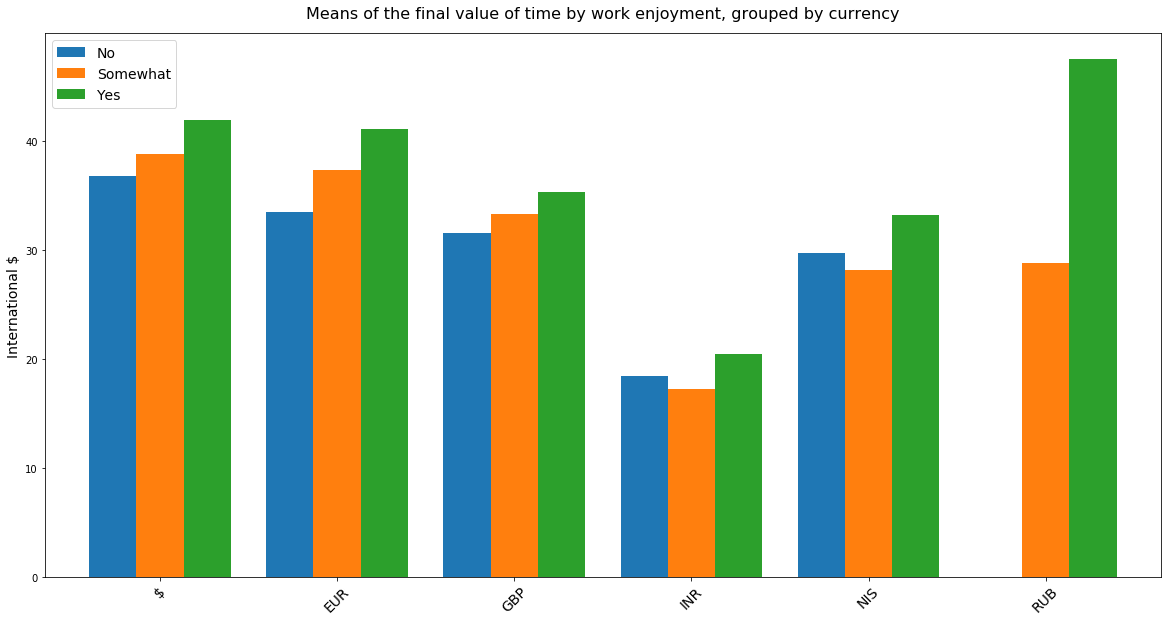

In [124]:
#chart with all currencies
labels = enjoy_bycurrency_mean_e['symbol']
x = np.arange(len(labels))
ax = enjoy_bycurrency_mean_e.plot(kind='bar',figsize=(20, 10),width=0.8)

title = f"Means of the final value of time by work enjoyment, grouped by currency"
ax.set_ylabel("International $", size=14)
ax.set_xticklabels(labels, fontsize=14, rotation=45)
ax.set_title(title, pad=15, fontsize=16)
ax.legend(fontsize=14)

plt.show()

fig.tight_layout()

First thing that comes out is that those who don't enjoy their work in India and Israel value their time higher than those who enjoy their work somewhat. This is in contrast to respondents using GBP, USD, and EUR. No data for Russia to make this comparison. 

It would be interesting to compare that to earnings. 

In [125]:
hours = basetv_noout[['employment', 'symbol', 'enjoy', 'totalhoursyearly', 'totalannualwage', 'A_dol', 'B_dol', 'C_dol', 'D_dol', 'E_dol']]
#check for nans
hours.isna().sum()

employment          0
symbol              0
enjoy               0
totalhoursyearly    0
totalannualwage     0
A_dol               0
B_dol               0
C_dol               0
D_dol               0
E_dol               0
dtype: int64

In [126]:
hours.shape

(9887, 10)

In [127]:
# check how many are zeros
hours['totalannualwage'].value_counts()

0.0         2058
52000.0       60
31200.0       49
62400.0       45
30000.0       45
            ... 
84500.0        1
113900.0       1
29577.6        1
207400.0       1
235500.0       1
Name: totalannualwage, Length: 4103, dtype: int64

Steps:
- calculate total wage in international USD
- calculate wage per hour in inernational USD 
- group people by earning levels (How?)
- plot value of time by earning level

In [128]:
# normalise all wages
conditions = [
    (basetv_noout['symbol'] == 'GBP'),
    (basetv_noout['symbol'] == '$'),  
    (basetv_noout['symbol'] == 'INR'),
    (basetv_noout['symbol'] == 'NIS'),
    (basetv_noout['symbol'] == 'EUR'),
    (basetv_noout['symbol'] == 'RUB')
]

choices = [basetv_noout['totalannualwage']/0.68, basetv_noout['totalannualwage']/1, basetv_noout['totalannualwage']/21.107, basetv_noout['totalannualwage']/3.687, basetv_noout['totalannualwage']/0.706, basetv_noout['totalannualwage']/25.701]
basetv_noout['totalannualwage_dol'] = np.select(conditions, choices, default=0)
hours['totalannualwage_dol'] = np.select(conditions, choices, default=0)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [129]:
basetv_noout['totalannualwage_dol'].value_counts()

0.000000        2058
52000.000000      54
62400.000000      44
50000.000000      42
31200.000000      41
                ... 
2800.000000        1
21416.430595       1
41011.650000       1
63635.475997       1
32512.500000       1
Name: totalannualwage_dol, Length: 4686, dtype: int64

In [130]:
hours['totalhoursyearly'].isna().sum()

0

In [131]:
# calculate dollar per hour value
hours['dol_per_h'] = hours['totalannualwage_dol']/hours['totalhoursyearly']

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [132]:
# chekc for nans
hours['dol_per_h'].isna().sum()

2052

In [133]:
# fill the nans with 0s
hours['dol_per_h']= hours['dol_per_h'].fillna(0)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [134]:
print(hours.shape[0])
hours.head()

9887


,employment,symbol,enjoy,totalhoursyearly,totalannualwage,A_dol,B_dol,C_dol,D_dol,E_dol,totalannualwage_dol,dol_per_h
0,1,$,Somewhat,1970.0,39570.0,20.0,12.5,200.000000,20.000000,20.000000,39570.0,20.086294
2,1,$,Yes,2340.0,49495.0,30.0,12.5,50.000000,32.927350,31.463675,49495.0,21.151709
4,1,$,Yes,2600.0,129500.0,49.0,12.5,50.000000,101.923077,49.500000,129500.0,49.807692
5,1,$,Somewhat,2400.0,120700.0,75.0,20.0,100.000000,100.582333,87.500000,120700.0,50.291667
6,1,$,Yes,2000.0,52000.0,35.0,1.5,33.333333,19.500000,26.416667,52000.0,26.000000


In [135]:
hours.to_excel("CT_converted.xlsx")

In [136]:
# create bins for the annual wage, remove zero values
hours_n0 = hours.loc[hours['totalannualwage_dol'] != 0]
print(hours_n0.shape[0])

7829


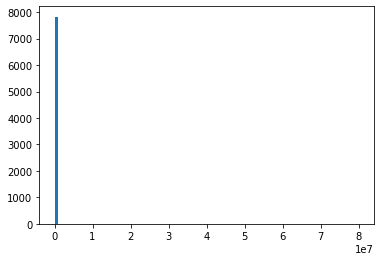

In [137]:
#calc number of bins
bins = int(np.sqrt(len(hours_n0)))

# plot histogram
_=plt.hist(hours_n0['totalannualwage_dol'], bins=bins)
plt.show()

Something seems off here.

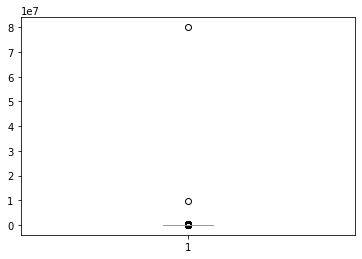

In [138]:
# chck for outliers
_ = plt.boxplot(hours_n0['totalannualwage_dol'])
plt.show()

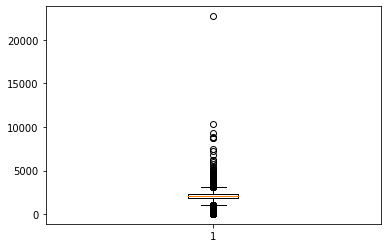

In [139]:
_ = plt.boxplot(hours_n0['totalhoursyearly'])
plt.show()

Clearly an outlier.

In [140]:
# check distribution
hours_n0['totalannualwage_dol'].describe()

count    7.829000e+03
mean     6.667506e+04
std      9.117005e+05
min      1.610832e+02
25%      2.823529e+04
50%      4.700000e+04
75%      7.280000e+04
max      8.008000e+07
Name: totalannualwage_dol, dtype: float64

In [141]:
# how convenient someone wrote a "remove outliers" function before! <3
hours_n0_clean = remove_outliers(hours_n0,'totalannualwage_dol')
hours_n0_clean.head()

,employment,symbol,enjoy,totalhoursyearly,totalannualwage,A_dol,B_dol,C_dol,D_dol,E_dol,totalannualwage_dol,dol_per_h
0,1,$,Somewhat,1970.0,39570.0,20.0,12.5,200.000000,20.000000,20.000000,39570.0,20.086294
2,1,$,Yes,2340.0,49495.0,30.0,12.5,50.000000,32.927350,31.463675,49495.0,21.151709
4,1,$,Yes,2600.0,129500.0,49.0,12.5,50.000000,101.923077,49.500000,129500.0,49.807692
5,1,$,Somewhat,2400.0,120700.0,75.0,20.0,100.000000,100.582333,87.500000,120700.0,50.291667
6,1,$,Yes,2000.0,52000.0,35.0,1.5,33.333333,19.500000,26.416667,52000.0,26.000000


In [142]:
#removing outliers in the time worked column, absolute max time of 18hrs a day is around 25k hrs a year
hours_n0_clean = hours_n0_clean[hours_n0_clean['totalhoursyearly']<25000]

In [143]:
# test for ratio values calculated before grouping
hours_n0_clean['ratio_test'] = hours_n0_clean['E_dol']/hours_n0_clean['dol_per_h']
hours_n0_clean.groupby('symbol').mean()

,totalhoursyearly,totalannualwage,A_dol,B_dol,C_dol,D_dol,E_dol,totalannualwage_dol,dol_per_h,ratio_test
symbol,,,,,,,,,,
$,2005.473339,5.332192e+04,40.281419,12.555253,128.195526,38.811008,38.911740,53321.924131,26.229208,1.712549
EUR,1906.271302,2.858150e+04,44.606423,10.165524,170.402896,33.718768,38.774780,40483.716952,21.514034,2.042259
GBP,1889.836364,2.808220e+04,35.917494,10.984488,153.104884,32.025153,34.013560,41297.353409,21.629402,1.748052
INR,2310.054545,8.065621e+05,27.218889,5.553091,17.360318,30.394445,18.575532,38213.013365,16.785719,1.421657
NIS,2242.838462,1.472300e+05,36.677724,8.056581,69.137580,28.252741,31.082320,39932.182345,17.790833,2.699557
RUB,1747.000000,1.051204e+06,49.209263,18.976976,47.221367,39.968754,37.929585,40901.273739,21.158839,1.858310


In [144]:
#clean hours minus russian respondents
hours_n0_clean_norus = hours_n0_clean[hours_n0_clean['symbol']!='RUB']

In [145]:
# this just exports the df with employed people and no outliers
#hours_n0_clean.to_excel("CT_converted_no_outliers.xlsx")

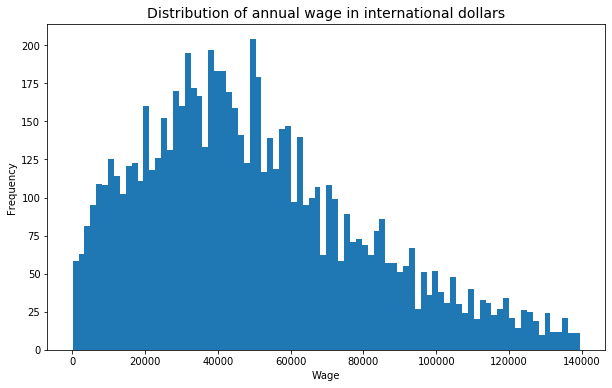

In [146]:
# plot histogram of the annual wage in international dollars
fig = plt.figure(figsize=(10,6))
bins=int(np.sqrt(len(hours_n0_clean)))
_=plt.hist(hours_n0_clean['totalannualwage_dol'], bins=bins)
plt.title("Distribution of annual wage in international dollars",fontsize=14)
plt.ylabel('Frequency')
plt.xlabel('Wage')
plt.show()

In [147]:
# plot mean wage by currency
mean_wage_by_currency = hours_n0_clean.groupby('symbol').mean()
mean_wage_by_currency.reset_index(inplace=True)

In [148]:
#plot mean wage by currency with no rus
mean_wage_by_currency_norus = hours_n0_clean_norus.groupby('symbol').mean()
mean_wage_by_currency_norus.reset_index(inplace=True)

In [149]:
mean_wage_by_currency

,symbol,totalhoursyearly,totalannualwage,A_dol,B_dol,C_dol,D_dol,E_dol,totalannualwage_dol,dol_per_h,ratio_test
0,$,2005.473339,5.332192e+04,40.281419,12.555253,128.195526,38.811008,38.911740,53321.924131,26.229208,1.712549
1,EUR,1906.271302,2.858150e+04,44.606423,10.165524,170.402896,33.718768,38.774780,40483.716952,21.514034,2.042259
2,GBP,1889.836364,2.808220e+04,35.917494,10.984488,153.104884,32.025153,34.013560,41297.353409,21.629402,1.748052
3,INR,2310.054545,8.065621e+05,27.218889,5.553091,17.360318,30.394445,18.575532,38213.013365,16.785719,1.421657
4,NIS,2242.838462,1.472300e+05,36.677724,8.056581,69.137580,28.252741,31.082320,39932.182345,17.790833,2.699557
5,RUB,1747.000000,1.051204e+06,49.209263,18.976976,47.221367,39.968754,37.929585,40901.273739,21.158839,1.858310


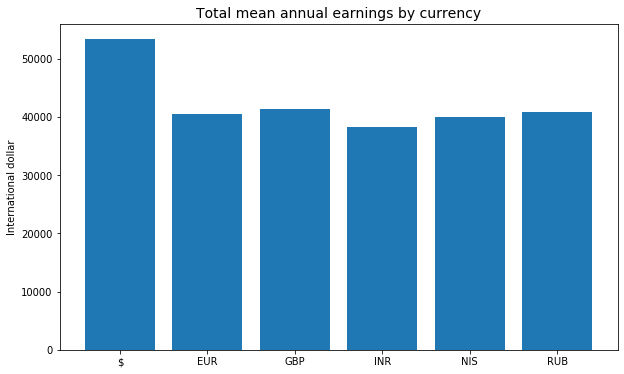

In [150]:
# figure with all currencies
fig = plt.figure(figsize=(10,6))

x = np.arange(len(labels))
_ = plt.bar(x, height=mean_wage_by_currency['totalannualwage_dol'])

plt.xticks(x, labels)
plt.ylabel("International dollar")
plt.title('Total mean annual earnings by currency', fontsize=14)
plt.show()

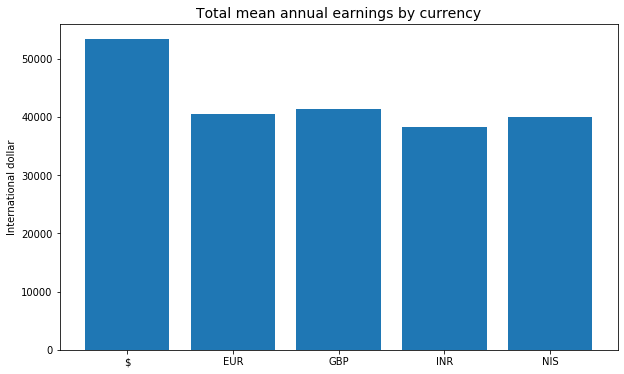

In [151]:
#plot the above with no russian respondents
fig = plt.figure(figsize=(10,6))

labels = mean_wage_by_currency_norus['symbol'].unique()
x = np.arange(len(labels))
_ = plt.bar(x, height=mean_wage_by_currency_norus['totalannualwage_dol'])

plt.xticks(x, labels)
plt.ylabel("International dollar")
plt.title('Total mean annual earnings by currency', fontsize=14)
plt.show()

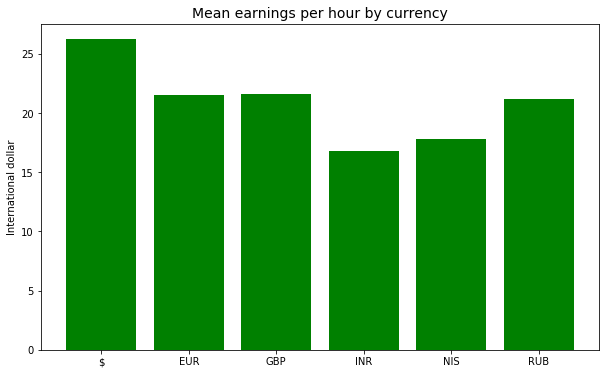

In [152]:
# plot mean earnings per hour by currency, all currencies
fig = plt.figure(figsize=(10,6))
labels = mean_wage_by_currency['symbol'].unique()
x = np.arange(len(labels))

# define arays for plotting
_ = plt.bar(x, height=mean_wage_by_currency['dol_per_h'], color='green')
plt.xticks(x, labels)
plt.title('Mean earnings per hour by currency', fontsize=14)
plt.ylabel("International dollar")
plt.show()

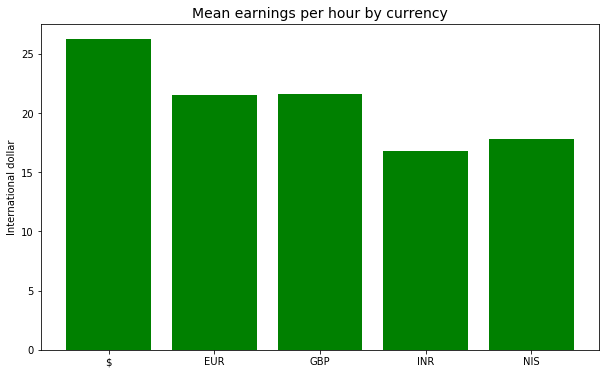

In [153]:
# plot mean earnings per hour by currency (no rus)
fig = plt.figure(figsize=(10,6))

labels = mean_wage_by_currency_norus['symbol'].unique()
x = np.arange(len(labels))

# define arays for plotting
_ = plt.bar(x, height=mean_wage_by_currency_norus['dol_per_h'], color='green')
plt.xticks(x, labels)
plt.title('Mean earnings per hour by currency', fontsize=14)
plt.ylabel("International dollar")
plt.show()

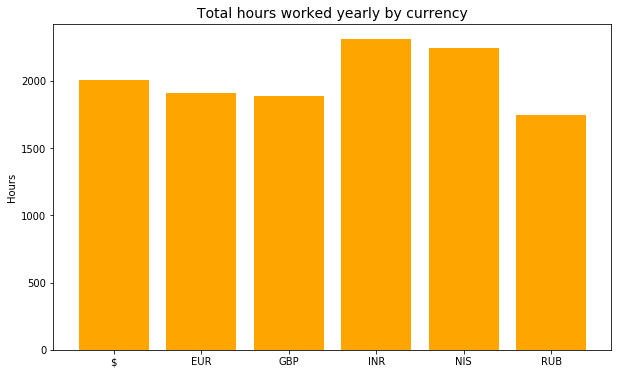

In [154]:
#plot mean wage by currency for all currencies
fig = plt.figure(figsize=(10,6))

labels = mean_wage_by_currency['symbol'].unique()
x = np.arange(len(labels))

# define arays for plotting
_ = plt.bar(x, height=mean_wage_by_currency['totalhoursyearly'], color='orange')
plt.xticks(x, labels)
plt.title('Total hours worked yearly by currency', fontsize=14)
plt.ylabel("Hours")
plt.show()

In [155]:
# #plot mean wage by currency with no Russian respondents
# fig = plt.figure(figsize=(10,6))

# labels = mean_wage_by_currency_norus['symbol'].unique()
# x = np.arange(len(labels))

# # define arays for plotting
# _ = plt.bar(x, height=mean_wage_by_currency_norus['totalhoursyearly'], color='orange')
# plt.xticks(x, labels)
# plt.title('Total hours worked yearly by currency', fontsize=14)
# plt.ylabel("Hours")
# plt.show()

In [156]:
mt = mean_wage_by_currency.set_index('symbol')
mt = mt[["A_dol","B_dol","C_dol","D_dol", "E_dol","totalannualwage_dol", "dol_per_h",'totalhoursyearly']]
#dropping the rubles not to skew results
mt.drop("RUB",inplace=True)

In [157]:
mt

,A_dol,B_dol,C_dol,D_dol,E_dol,totalannualwage_dol,dol_per_h,totalhoursyearly
symbol,,,,,,,,
$,40.281419,12.555253,128.195526,38.811008,38.911740,53321.924131,26.229208,2005.473339
EUR,44.606423,10.165524,170.402896,33.718768,38.774780,40483.716952,21.514034,1906.271302
GBP,35.917494,10.984488,153.104884,32.025153,34.013560,41297.353409,21.629402,1889.836364
INR,27.218889,5.553091,17.360318,30.394445,18.575532,38213.013365,16.785719,2310.054545
NIS,36.677724,8.056581,69.137580,28.252741,31.082320,39932.182345,17.790833,2242.838462


In [158]:
max_values = mt.idxmax()
min_values = mt.idxmin()
print(min_values['totalannualwage_dol'])
print(min_values['totalhoursyearly'])

INR
GBP


In [159]:
print("The lowest annual wage is earned by those who earn in", min_values['totalannualwage_dol'], 
      "\nand the lowest pay per hour is earned by those who earn in", min_values['dol_per_h'],
      "\nThe highest annual wage is earned by those who earn in", max_values['totalannualwage_dol'], 
      "\nand the highest pay per hour is earned by those who earn in", max_values['dol_per_h'],
      ". \nEarners of", max_values['totalhoursyearly'], "work the highest number of hours per year, and"
      "\nearners of", min_values['totalhoursyearly'], "work the lowest number of hours per year.")

The lowest annual wage is earned by those who earn in INR 
and the lowest pay per hour is earned by those who earn in INR 
The highest annual wage is earned by those who earn in $ 
and the highest pay per hour is earned by those who earn in $ . 
Earners of INR work the highest number of hours per year, and
earners of GBP work the lowest number of hours per year.


### Value of time vs. earning per hour

In [160]:
mt['E_to_perh_ratio'] = mt['E_dol']/mt['dol_per_h']
mt_sorted = mt['E_to_perh_ratio'].sort_values()
mt_sorted

symbol
INR    1.106627
$      1.483527
GBP    1.572561
NIS    1.747097
EUR    1.802302
Name: E_to_perh_ratio, dtype: float64

In [161]:
mt['dol_per_h'].sort_values()

symbol
INR    16.785719
NIS    17.790833
EUR    21.514034
GBP    21.629402
$      26.229208
Name: dol_per_h, dtype: float64

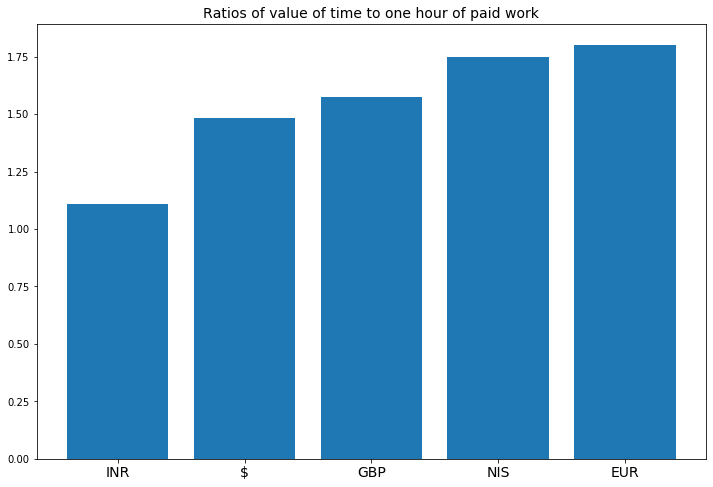

In [162]:
fig = plt.figure(figsize=(12,8))
labels = mt_sorted.index
x = np.arange(len(labels))

# _ = mt_sorted.plot(kind='bar')

# define arays for plotting
ax = plt.bar(x, height=mt_sorted)
plt.xticks(x, labels)

plt.title('Ratios of value of time to one hour of paid work', fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("")

plt.show()

**Conclusion**

While the highest annual wage and the highest pay per hour is earned by US$-earners, people who earn in other curencies value their time higher as compared to how much they earn. EUR earners value an hour of their time at 1.8x more than an hour of paid work, NIS-earners 1.75x more and GBP earners 1.57x more. The last onesare INR earners, 1.11x on average. 

Looking at the absolute average values of earnings per hour it suggests that earning more per hours doesn't lead to valuing one's time more.

### Quesions:

It'd be ideal to see how enjoyment is correlated with earnings, as in: are people who earn more, more likely enjoy their work more? But it would be hard to execute since enjoyment is measured on a 3 point scale. Would it make sense to check this? How can this be done? 

# Predicting final value of time

### Questions to answer: 

 1. Can we predict final value of time based on salary, employment, currency, etc. (factors **other than** questions A-D)?
 2. Adding the answer to which question (out of questions A-D) would make the results more accurate? 
 
Doing a linear regression allows to factor in enjoyment to the prediction.
 
The problem here might be that the variables are correlated (presumably more total hours means higher annual wage).

In [163]:
#create a base table
table_for_model = basetv_noout[['employment', 'wageorsalary', 'symbol', 'enjoy', 'jobnumber', 'totalhoursyearly', 'totalannualwage', 'E_dol']]
table_for_model.head()

,employment,wageorsalary,symbol,enjoy,jobnumber,totalhoursyearly,totalannualwage,E_dol
0,1,0,$,Somewhat,2.0,1970.0,39570.0,20.000000
2,1,2,$,Yes,1.0,2340.0,49495.0,31.463675
4,1,2,$,Yes,1.0,2600.0,129500.0,49.500000
5,1,2,$,Somewhat,1.0,2400.0,120700.0,87.500000
6,1,0,$,Yes,1.0,2000.0,52000.0,26.416667


In [164]:
#check for nans 
table_for_model.isna().sum()

employment          0
wageorsalary        0
symbol              0
enjoy               0
jobnumber           0
totalhoursyearly    0
totalannualwage     0
E_dol               0
dtype: int64

### Process base table to prep for regression
We will use the replace function to turn the categriacal variables in "enjoy" column into labels, to make sure the values have the right weights (that is Enjoy has a higher vlaue than Somewhat). For the 'symbol' column we can use one hot encoding wit get dummies.

In [165]:
enjoy_encode = {"enjoy":{"Yes":3,"Somewhat":2,"No":1}}

In [166]:
table_for_model.replace(enjoy_encode,inplace=True )

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6666: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


In [167]:
# default drop first is False, which afaiu is not the best practice. 
table_for_model = pd.get_dummies(table_for_model, columns=["symbol"], drop_first=True)

In [168]:
table_for_model.head()

,employment,wageorsalary,enjoy,jobnumber,totalhoursyearly,totalannualwage,E_dol,symbol_EUR,symbol_GBP,symbol_INR,symbol_NIS,symbol_RUB
0,1,0,2,2.0,1970.0,39570.0,20.000000,0,0,0,0,0
2,1,2,3,1.0,2340.0,49495.0,31.463675,0,0,0,0,0
4,1,2,3,1.0,2600.0,129500.0,49.500000,0,0,0,0,0
5,1,2,2,1.0,2400.0,120700.0,87.500000,0,0,0,0,0
6,1,0,3,1.0,2000.0,52000.0,26.416667,0,0,0,0,0


In [169]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [170]:
# define predictors and response
x = table_for_model.drop(columns='E_dol')
y = table_for_model['E_dol']

#split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

# instantiate the model
lr = LinearRegression()

#fit the model
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [171]:
print(len(x), len(y))

9887 9887


In [172]:
# check coefficients
print(lr.coef_)

[ 7.15819525e+00  3.58805543e+00  2.21681046e+00 -7.04532568e+00
  5.20590085e-03  1.95524601e-07 -9.86681502e-02 -5.58879278e+00
 -2.10875337e+01 -8.83474084e+00 -8.73559950e+00]


In [173]:
coef_frame = pd.DataFrame(lr.coef_, x.columns, columns=['Coefficient'])
coef_frame

,Coefficient
employment,7.158195e+00
wageorsalary,3.588055e+00
enjoy,2.216810e+00
jobnumber,-7.045326e+00
totalhoursyearly,5.205901e-03
totalannualwage,1.955246e-07
symbol_EUR,-9.866815e-02
symbol_GBP,-5.588793e+00
symbol_INR,-2.108753e+01
symbol_NIS,-8.834741e+00


In [174]:
# predictions
predictions = lr.predict(x_test)

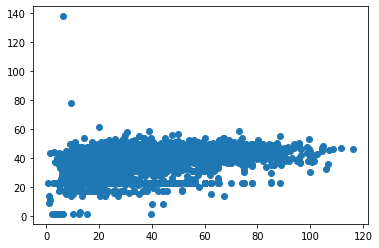

In [175]:
#visualise predictions
_ = plt.scatter(y_test,predictions)
plt.show()

This model sucks.

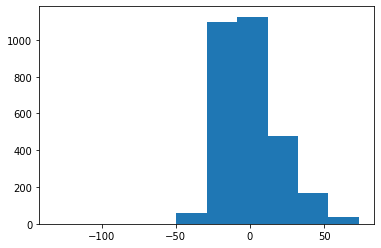

In [176]:
# plot residuals
_ = plt.hist(y_test - predictions)
plt.show()

In [177]:
# test
metrics.mean_squared_error(y_test, predictions)

364.89876058932407

Let's try to make this model better. Perhaps the currency encoding should be changed.

In [178]:
table_for_model_1 = basetv_noout[['employment', 'wageorsalary', 'symbol', 'enjoy', 'jobnumber', 'totalhoursyearly', 'totalannualwage', 'E_dol']]
table_for_model_1 = table_for_model_1.replace(enjoy_encode)
table_for_model_1.head()

,employment,wageorsalary,symbol,enjoy,jobnumber,totalhoursyearly,totalannualwage,E_dol
0,1,0,$,2,2.0,1970.0,39570.0,20.000000
2,1,2,$,3,1.0,2340.0,49495.0,31.463675
4,1,2,$,3,1.0,2600.0,129500.0,49.500000
5,1,2,$,2,1.0,2400.0,120700.0,87.500000
6,1,0,$,3,1.0,2000.0,52000.0,26.416667


In [179]:
#building in my bias into the model by creting a currency hierarchy? 
# hierarchy based on ratios in cell 188
symbol_encode = {"symbol":{"EUR":5,"NIS":4,"GBP":3,'$':2,"RUB":1,'INR':0}}

In [180]:
table_for_model_1 = table_for_model_1.replace(symbol_encode)

In [181]:
table_for_model_1.head()

,employment,wageorsalary,symbol,enjoy,jobnumber,totalhoursyearly,totalannualwage,E_dol
0,1,0,2,2,2.0,1970.0,39570.0,20.000000
2,1,2,2,3,1.0,2340.0,49495.0,31.463675
4,1,2,2,3,1.0,2600.0,129500.0,49.500000
5,1,2,2,2,1.0,2400.0,120700.0,87.500000
6,1,0,2,3,1.0,2000.0,52000.0,26.416667


In [182]:
# define predictors and response
x = table_for_model_1.drop(columns='E_dol')
y = table_for_model_1['E_dol']

#split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

# instantiate the model
lr = LinearRegression()

#fit the model
lr.fit(x_train, y_train)

# predictions
predictions = lr.predict(x_test)

# check accuracy
metrics.mean_squared_error(y_test, predictions)

377.55513455860745

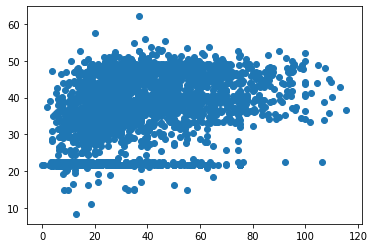

In [183]:
#visualise predictions
_ = plt.scatter(y_test,predictions)
plt.show()

Still sucks. In more professional words, the mean square error remains very high.

We can test adding an answer to one question to the other variable, to see how much it wil increase accuracy.

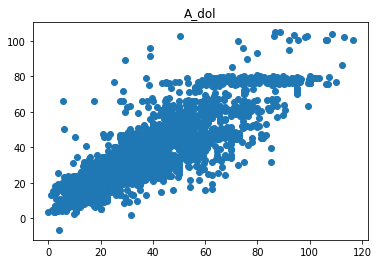

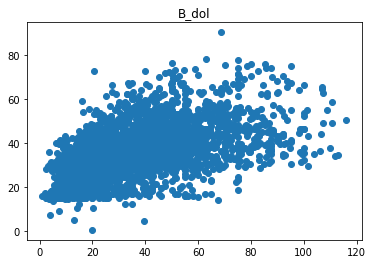

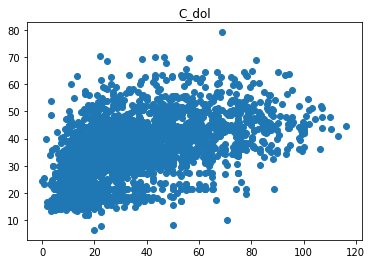

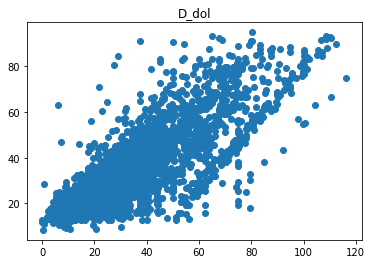

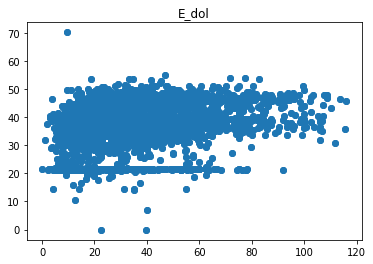

In [184]:
MSE_dict = {}

# run the model adding a different 'question column' (A-D) each time, calc the MSE & plot
for c in cols_normed:
    table_for_model_c = basetv_noout[['employment', 'wageorsalary', 'symbol', 'enjoy', 'jobnumber', 'totalhoursyearly', 'totalannualwage',c, 'E_dol']]
    table_for_model_c = table_for_model_c.replace(enjoy_encode)
    table_for_model_c = table_for_model_c.replace(symbol_encode)
    
    # define predictors and response
    x = table_for_model_c.drop(columns='E_dol')
    y = table_for_model_c['E_dol']

    #split into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

    # instantiate the model
    lr = LinearRegression()

    #fit the model
    lr.fit(x_train, y_train)

    # predictions
    predictions = lr.predict(x_test)

    # check accuracy
    accuracy = metrics.mean_squared_error(y_test, predictions)
    
    MSE_dict[c] = accuracy
    
    _ = plt.scatter(y_test, predictions)
    plt.title(c)
    plt.show()

In [185]:
MSE_dict

{'A_dol': 119.46817527262763,
 'B_dol': 330.0558332369977,
 'C_dol': 345.29604144304034,
 'D_dol': 163.1548022184124,
 'E_dol': 399.26475229530195}

**Conclusion**

Adding the answer to  question A to the model removes the highest amount of variance. It's still pretty miserable afaik. But, these results match the earlier correlation analysis which suggested answers to questions A & D are most highly correlated with the final value of time.

# Final conclusions
#### How employment changes how you value your time?
_Comparison of subgroups: employed vs unemployed_
For each currency group the employed people value their time higher than the unemployed. The differences are statistically significant.

#### Which question form the test is the best predictor of the final value of time?
_Correlations between answers & final value of time_
It's expected there would be positive correlations between each question and the final value of time. The higher peole valued their time in each task/question, the higher it means they value it overall. 

Some variables correlate with the final value of time more strongly than others —namely, answers to questions A and D (strong positive correlation between columns D & E: ~0.7951  and between A & E: ~0.8328). This suggests they are stronger predictors of the final value of time, an assumption we can test later by creating a model (fitting a linear regression). 

The strength of the correlations vary between currency groups, for example A-E for EUR is 0.878141 (over 0.04 higher than the total average), and D-E is 0.736351 (0.059 lower than average). The total is very strongly informed by the USD subgroup of values (the largest in the dataset). Similar results were shown by fitting a regression.

####  How does enjoyment influence value of time?
_Correlations between work enjoyment and final value of time_
There are significant differences in how people answer the questions (A-D) depending on how much they enjoy their work. This in turn produces significant differences in how they value their time. Even in comparison to those who only enjoy their work “somewhat”, people who enjoy their work (enjoy=Yes) value their time significantly higher.
In comparison to those who don't enjoy their work, those who enjoy their work somewhat have significantly higher values only in their answers to question A.
This adds to the evidence that question A is the strongest predictor of the final value of time.

When grouped by currency I turns out that, those who don't enjoy their work in India and Israel value their time higher than those who enjoy their work somewhat. This is in contrast to respondents using GBP, USD, and EUR.

#### How do earnings influence the final value of time?
_Ratios of final value of time and earnings per hour across currencies_

While the highest annual wage and the highest pay per hour is earned by US$-earners, people who earn in other curencies value their time higher as compared to how much they earn. EUR earners value an hour of their time at 1.8x more than an hour of paid work, NIS-earners 1.75x more and GBP earners 1.57x more. The last onesare INR earners, 1.11x on average.

Looking at the absolute average values of earnings per hour it seems that earning more per hour doesn't lead to valuing one's time more. 

## Next steps
It'd be nice to see if these results hold with a higher sample size, here the samples for some currencies (especially rubles) were very small.

We coud also do some clustering to check if there are other relationships between data points that were missed here. 